In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

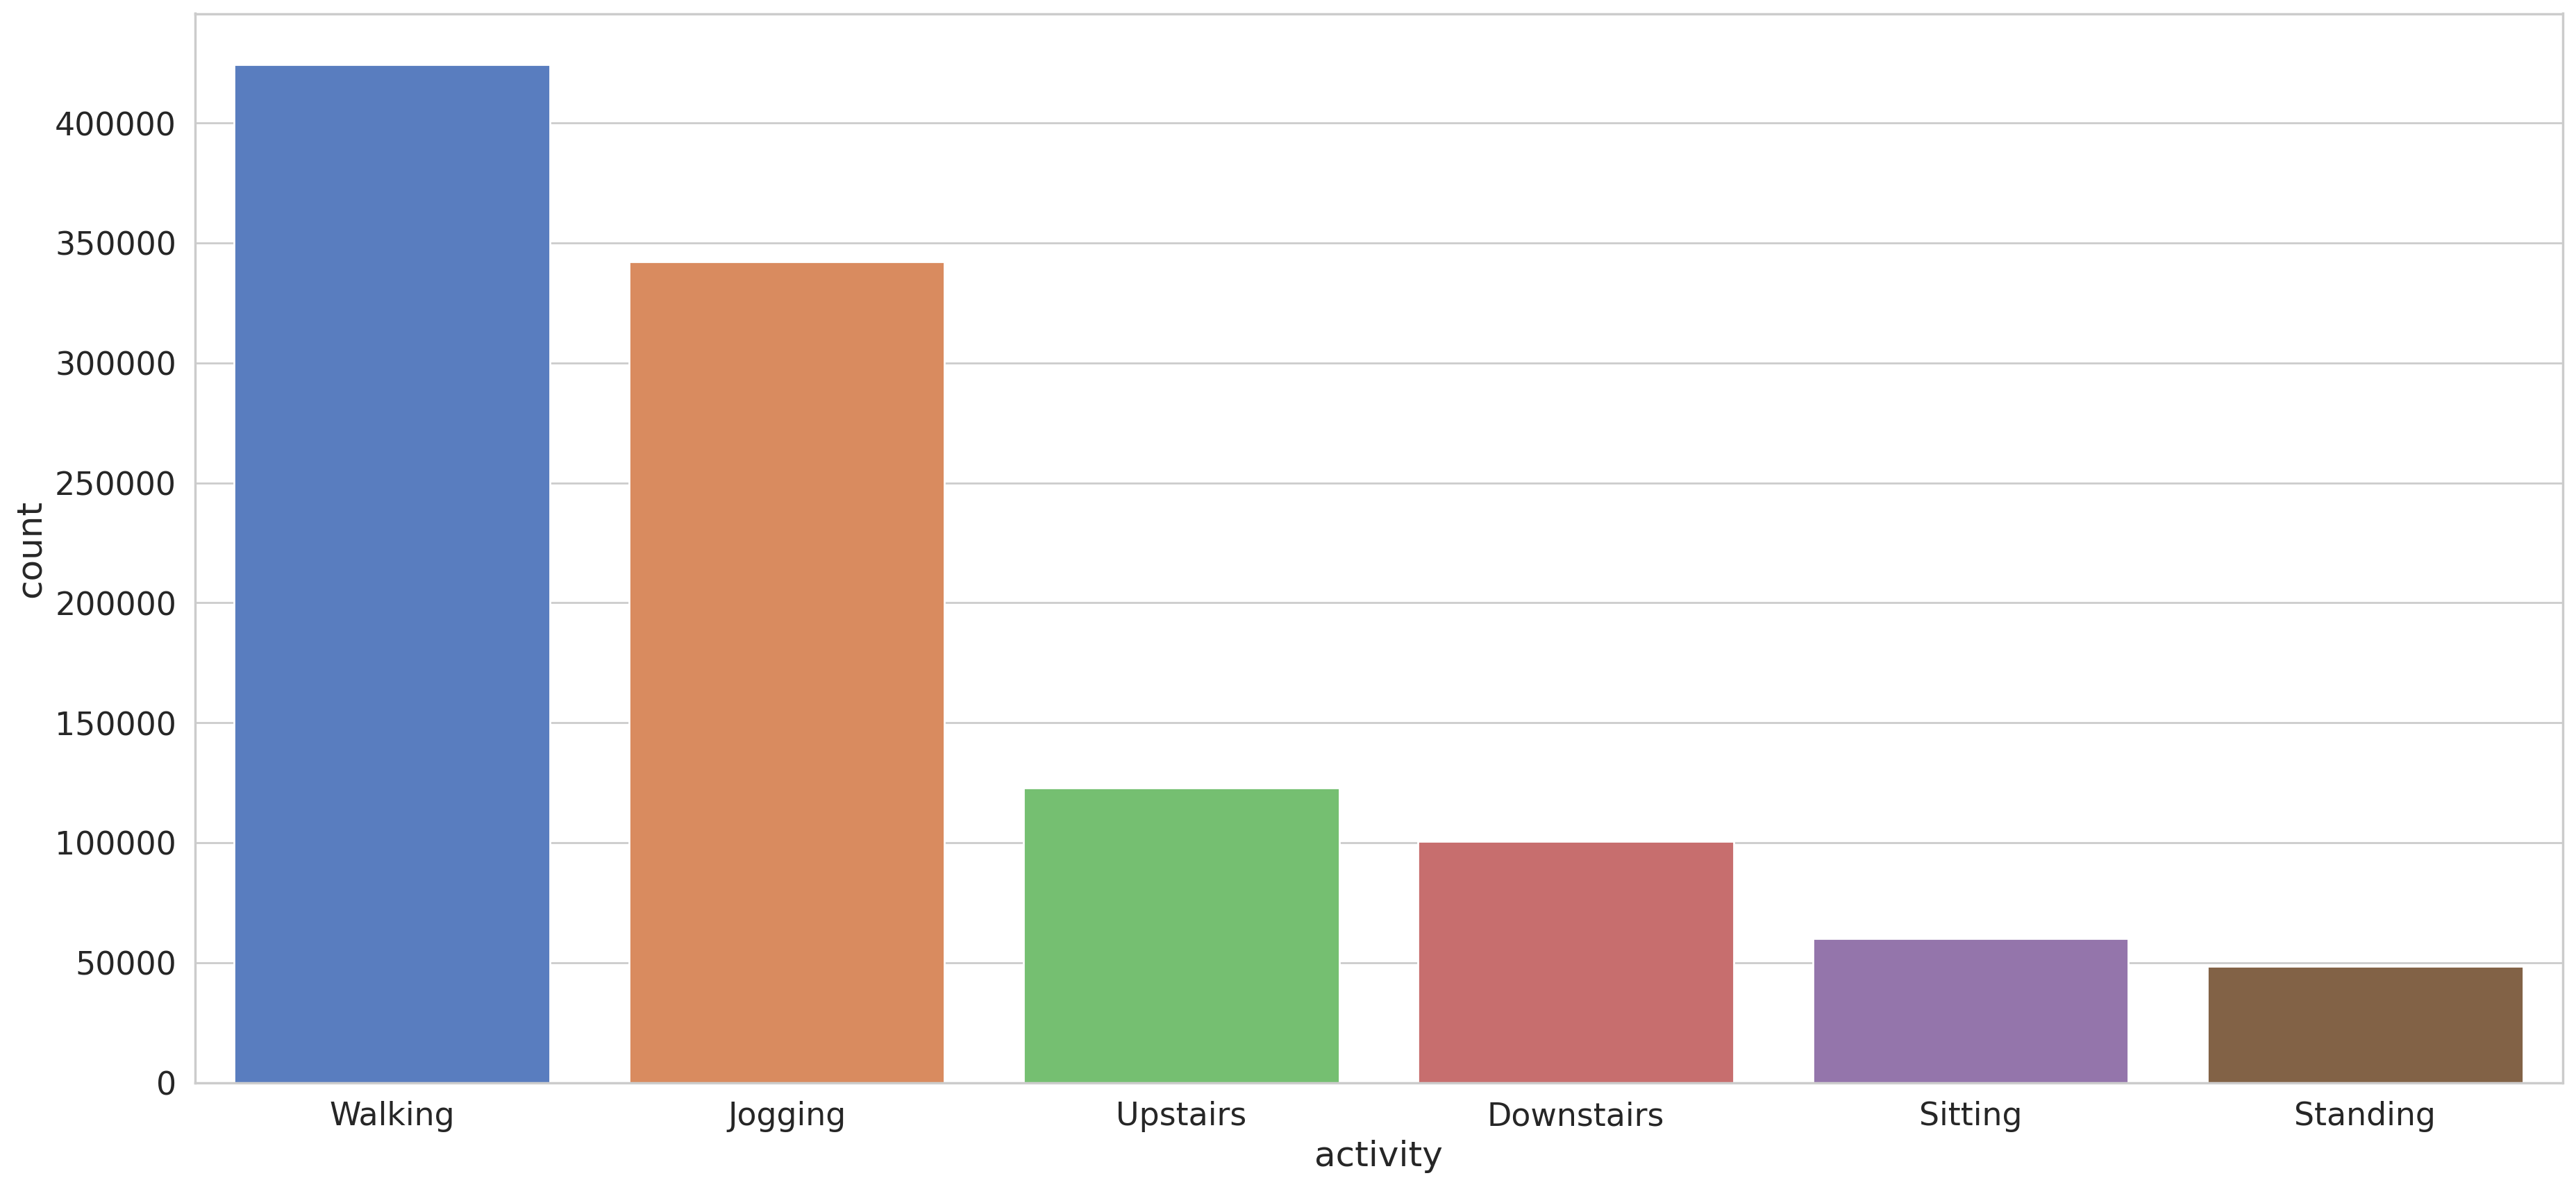

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

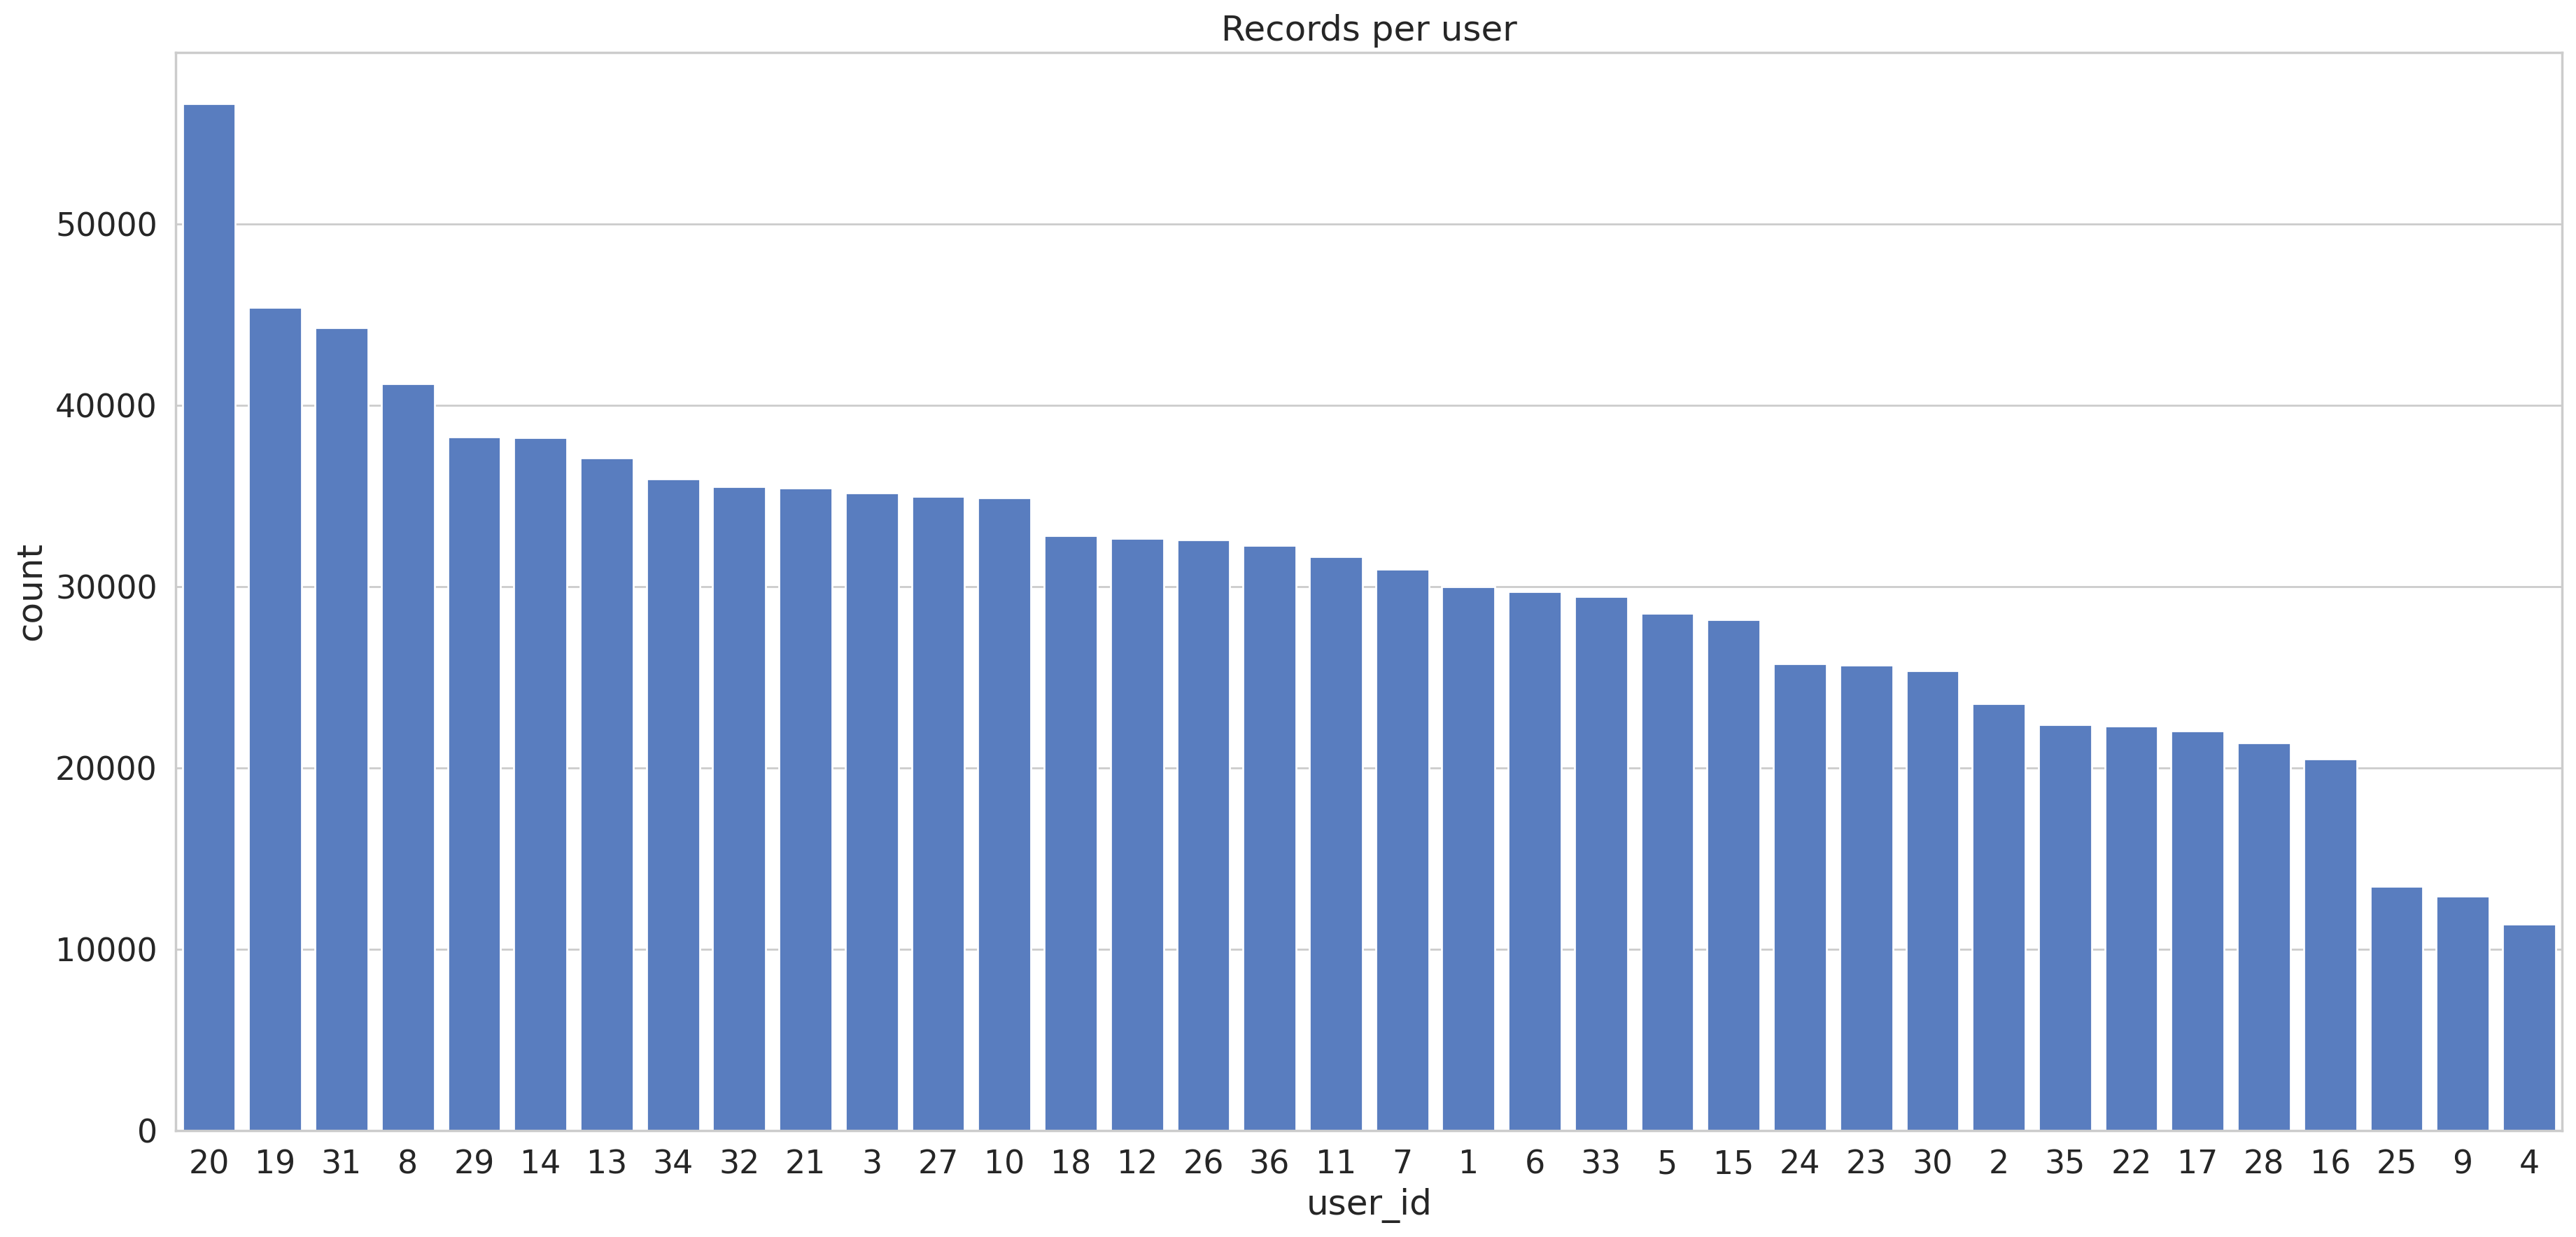

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


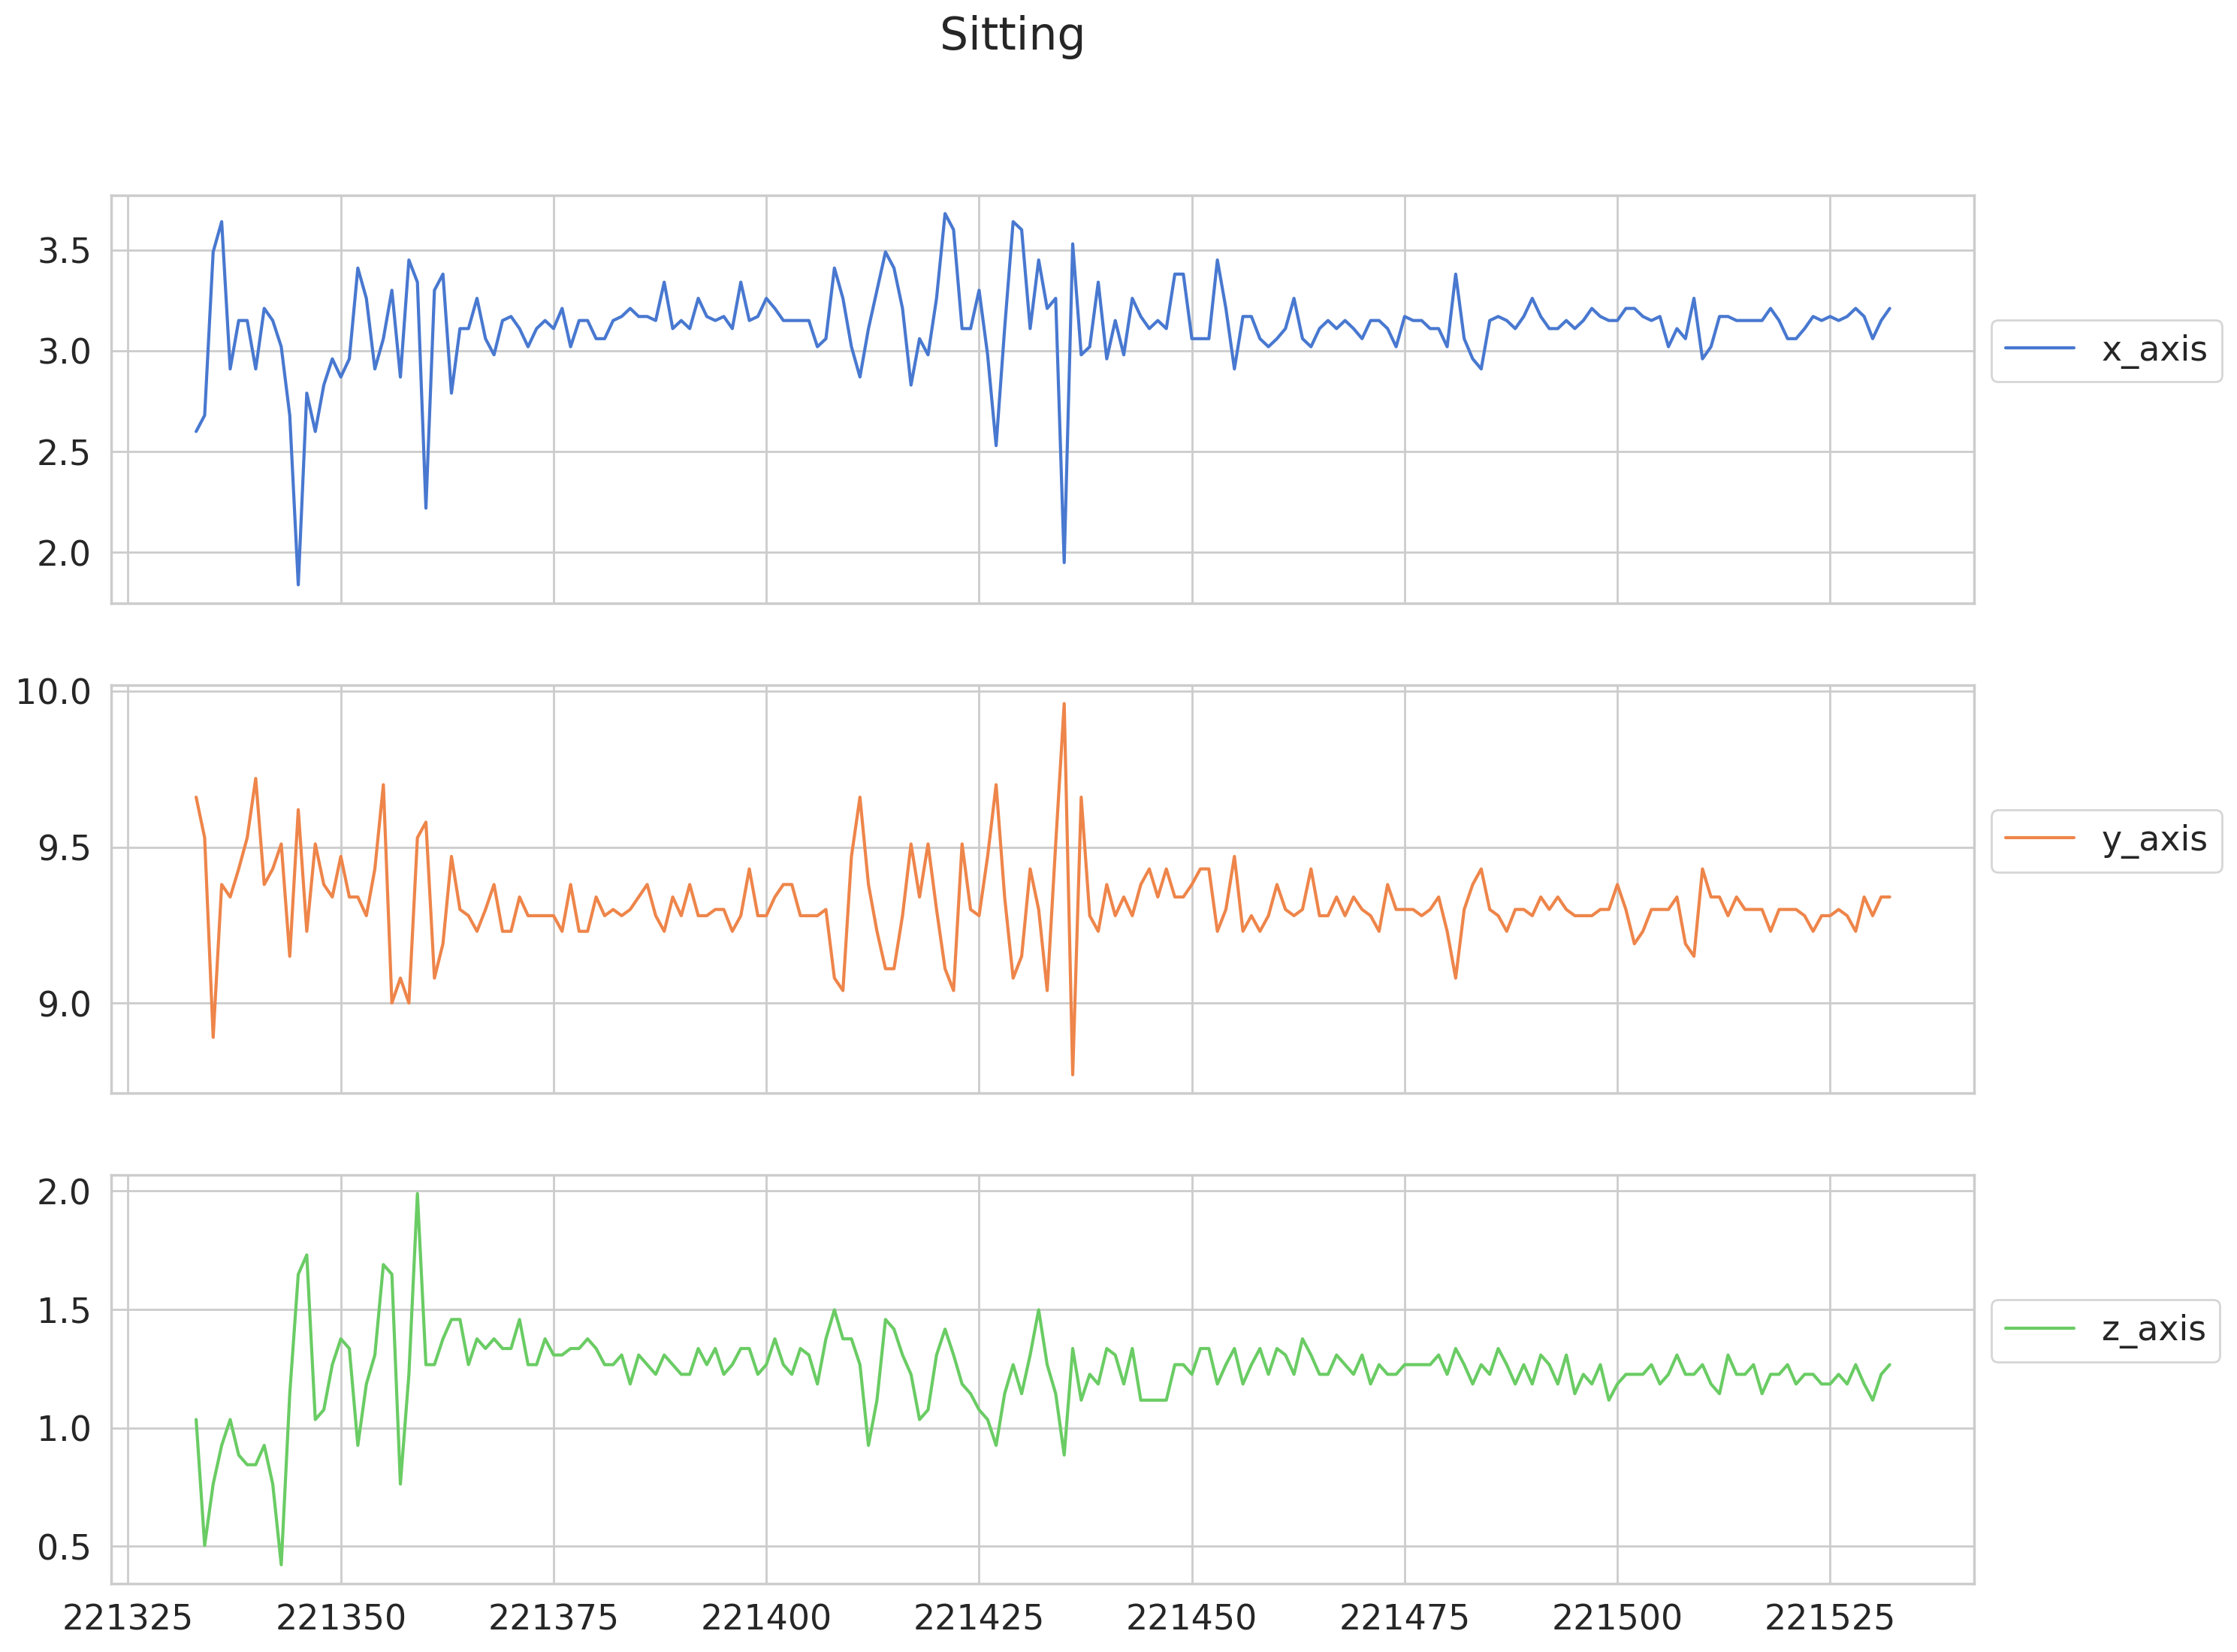

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] != 'Sitting') & (df['activity'] != 'Standing')].index
df.drop(indexes , inplace=True)


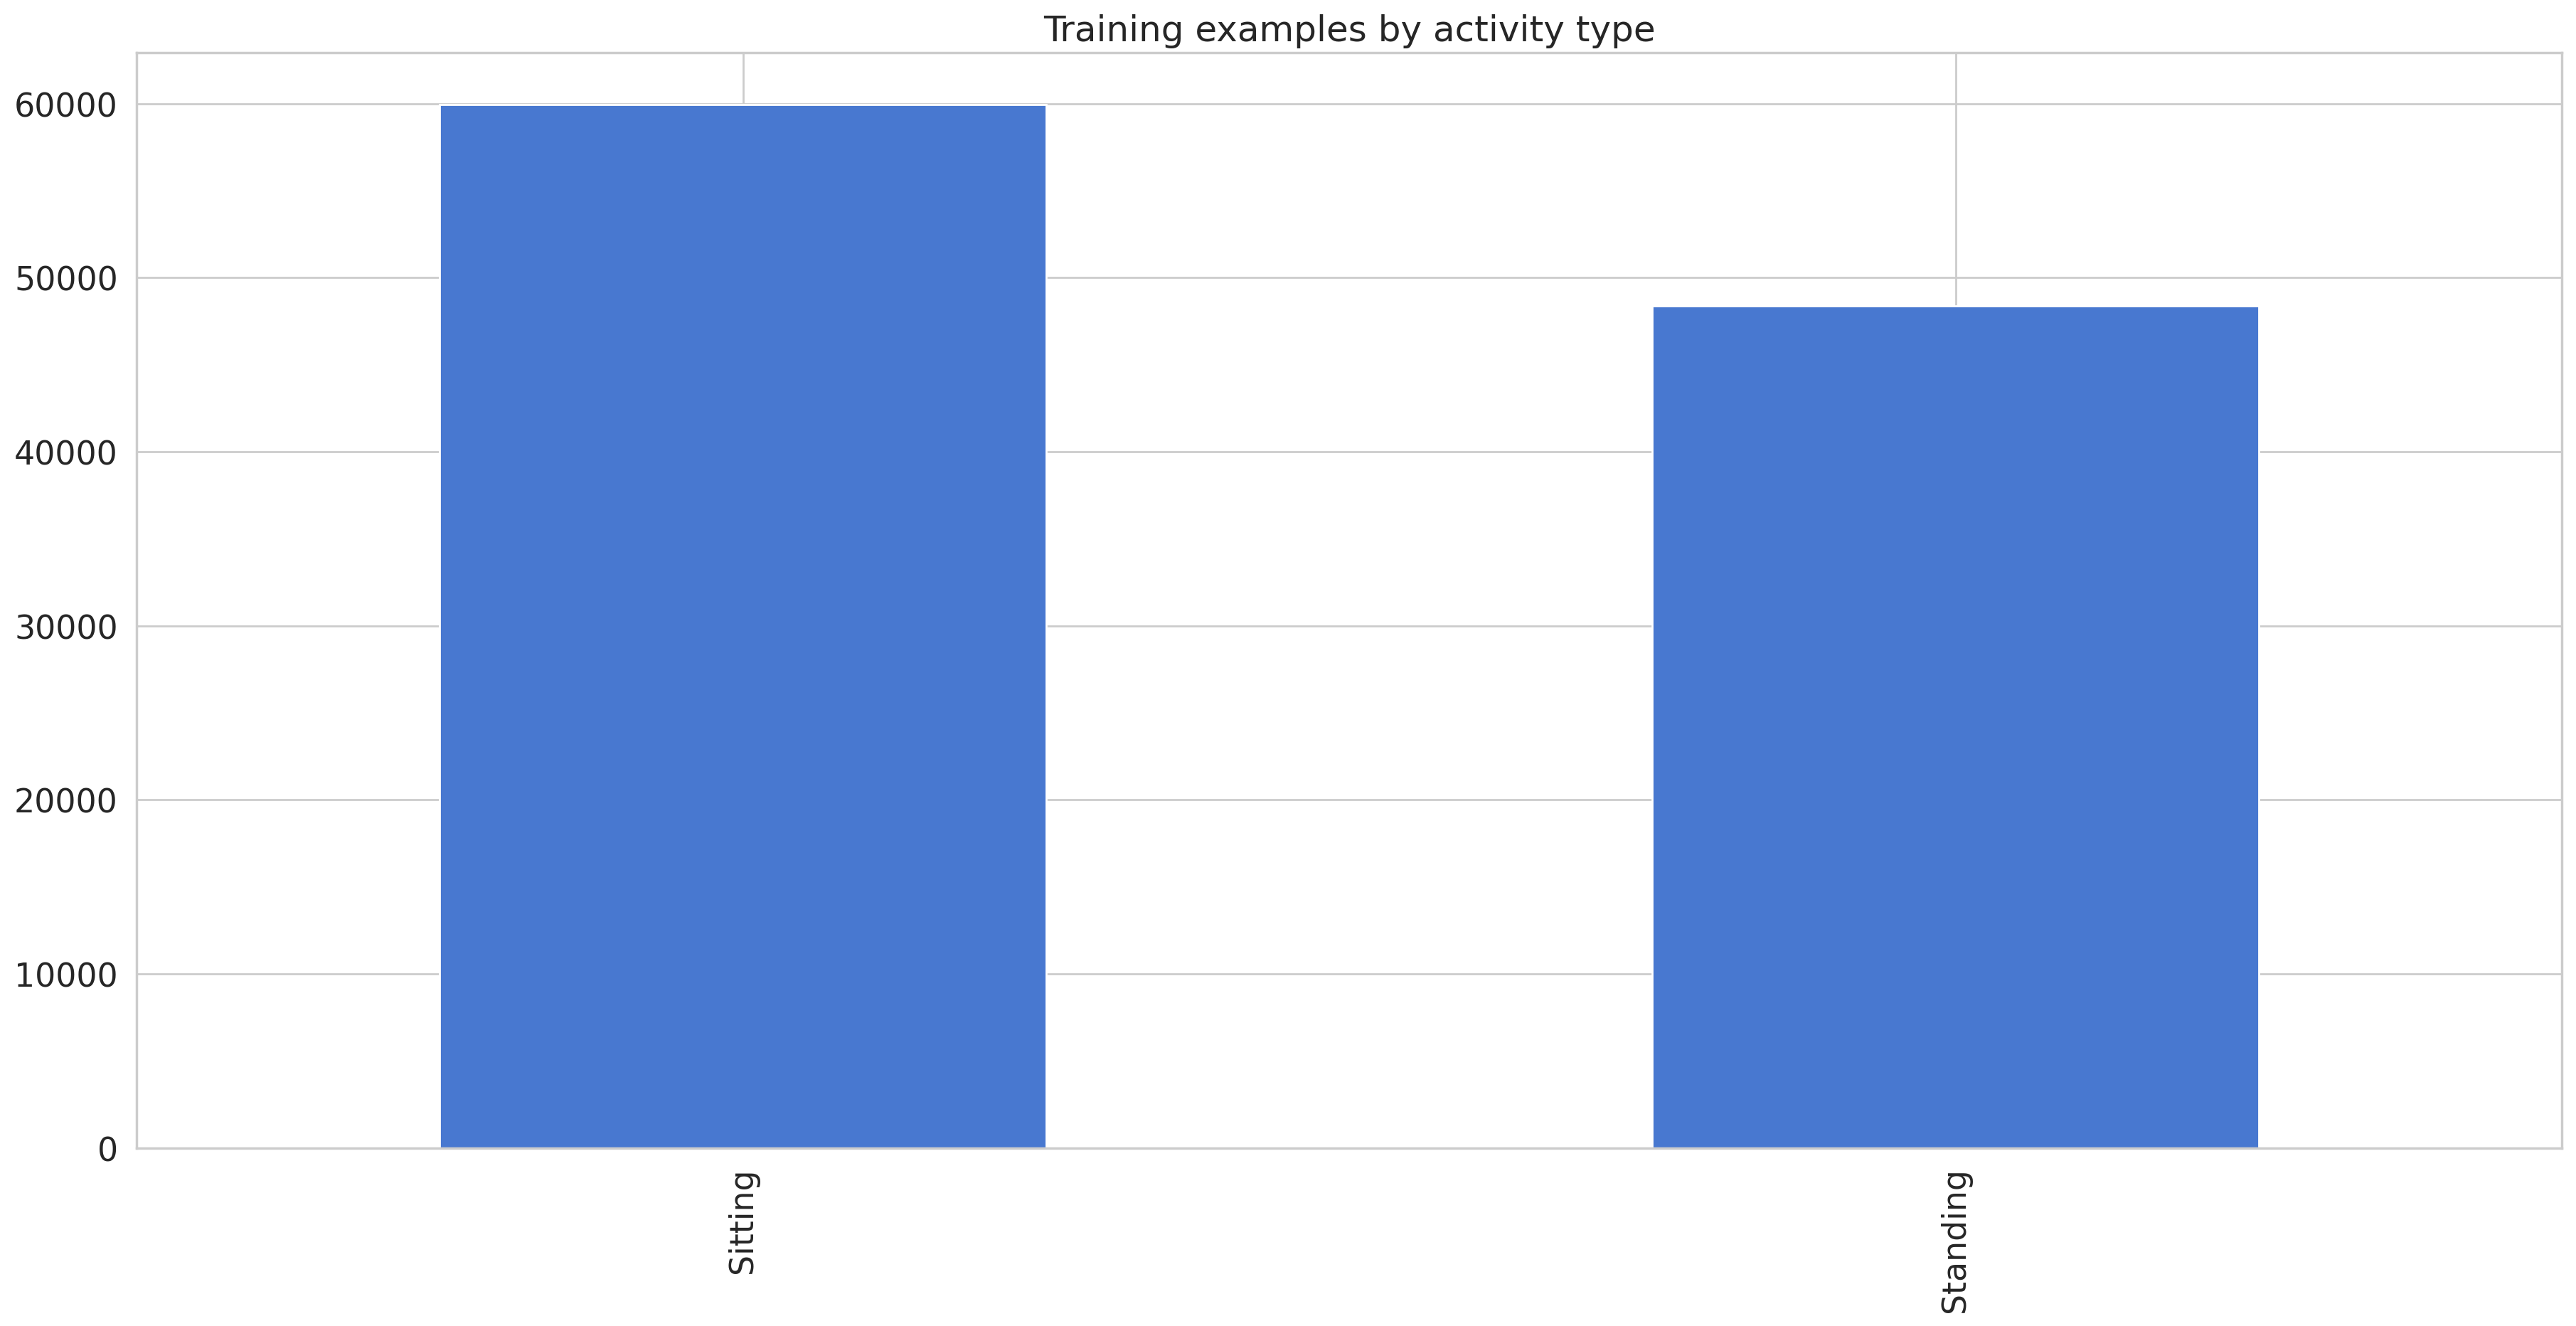

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id activity        timestamp    x_axis    y_axis    z_axis  \
221333        27  Sitting   12363992261000  0.490260  0.617689 -0.241746   
221334        27  Sitting   12364042279000  0.503247  0.599144 -0.311732   
221335        27  Sitting   12364092267000  0.634740  0.507846 -0.277636   
221336        27  Sitting   12364142316000  0.659091  0.577746 -0.256102   
221337        27  Sitting   12364192273000  0.540584  0.572040 -0.241746   
...          ...      ...              ...       ...       ...       ...   
1098200       19  Sitting  131623331483000  1.529221 -0.984308 -0.155468   
1098201       19  Sitting  131623371431000  1.535714 -0.968616 -0.150198   
1098202       19  Sitting  131623411592000  1.542208 -0.957204 -0.155468   
1098203       19  Sitting  131623491487000  1.529221 -0.968616 -0.150198   
1098204       19  Sitting  131623531465000  1.509740 -0.950071 -0.166008   

         ActivityEncoded  
221333                 4  
221334                 4  
221335                 4  
221336                 4  
221337                 4  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[108334 rows x 7 columns]

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6930, 50, 3) (6930, 1)
(2166, 50, 3) (2166, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(6930, 50, 3) (6930, 2) (2166, 50, 3) (2166, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 2)

# LSTM1


In [15]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               135168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 151746 (592.76 KB)
Trainable params: 151746 (592.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
7/7 [==============================] - 19s 726ms/step - loss: 0.5272 - accuracy: 0.8176 - val_loss: 0.2724 - val_accuracy: 0.9348
Epoch 2/10
7/7 [==============================] - 1s 93ms/step - loss: 0.2008 - accuracy: 0.9320 - val_loss: 0.1697 - val_accuracy: 0.9359
Epoch 3/10
7/7 [==============================] - 0s 74ms/step - loss: 0.1423 - accuracy: 0.9431 - val_loss: 0.1178 - val_accuracy: 0.9573
Epoch 4/10
7/7 [==============================] - 0s 64ms/step - loss: 0.1196 - accuracy: 0.9564 - val_loss: 0.1033 - val_accuracy: 0.9538
Epoch 5/10
7/7 [==============================] - 0s 76ms/step - loss: 0.1106 - accuracy: 0.9485 - val_loss: 0.0977 - val_accuracy: 0.9371
Epoch 6/10
7/7 [==============================] - 0s 65ms/step - loss: 0.1029 - accuracy: 0.9517 - val_loss: 0.0899 - val_accuracy: 0.9521
Epoch 7/10
7/7 [==============================] - 0s 58ms/step - loss: 0.0948 - accuracy: 0.9541 - val_loss: 0.0848 - val_accuracy: 0.9556
Epoch 8/10
7/7 [=========

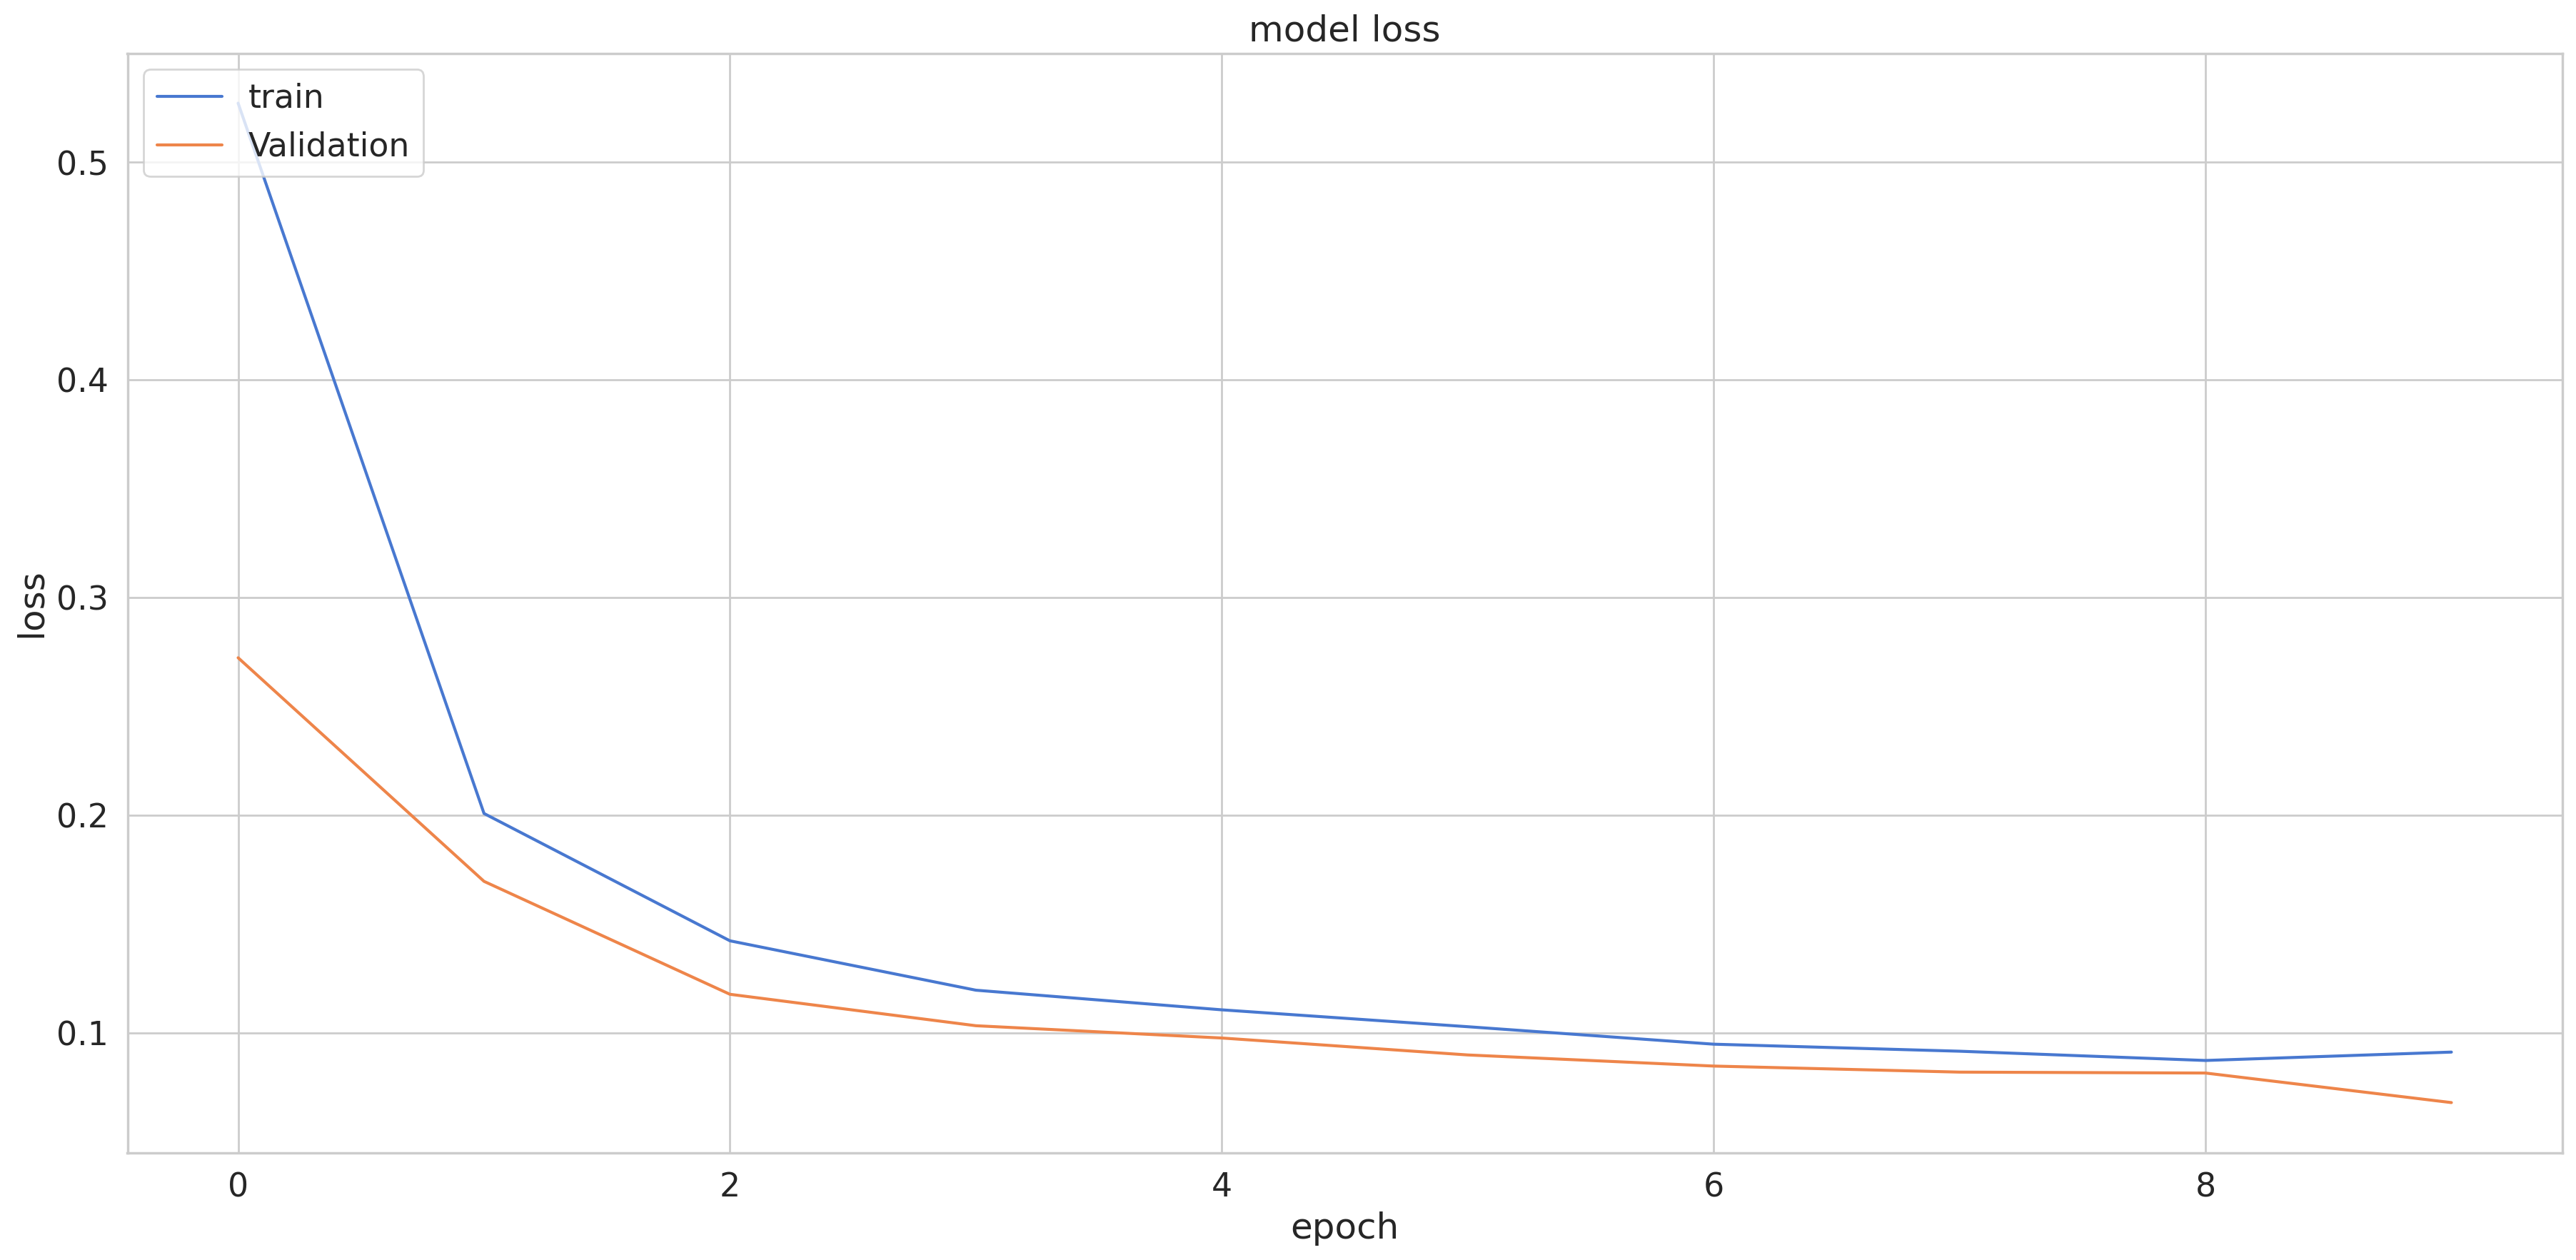

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

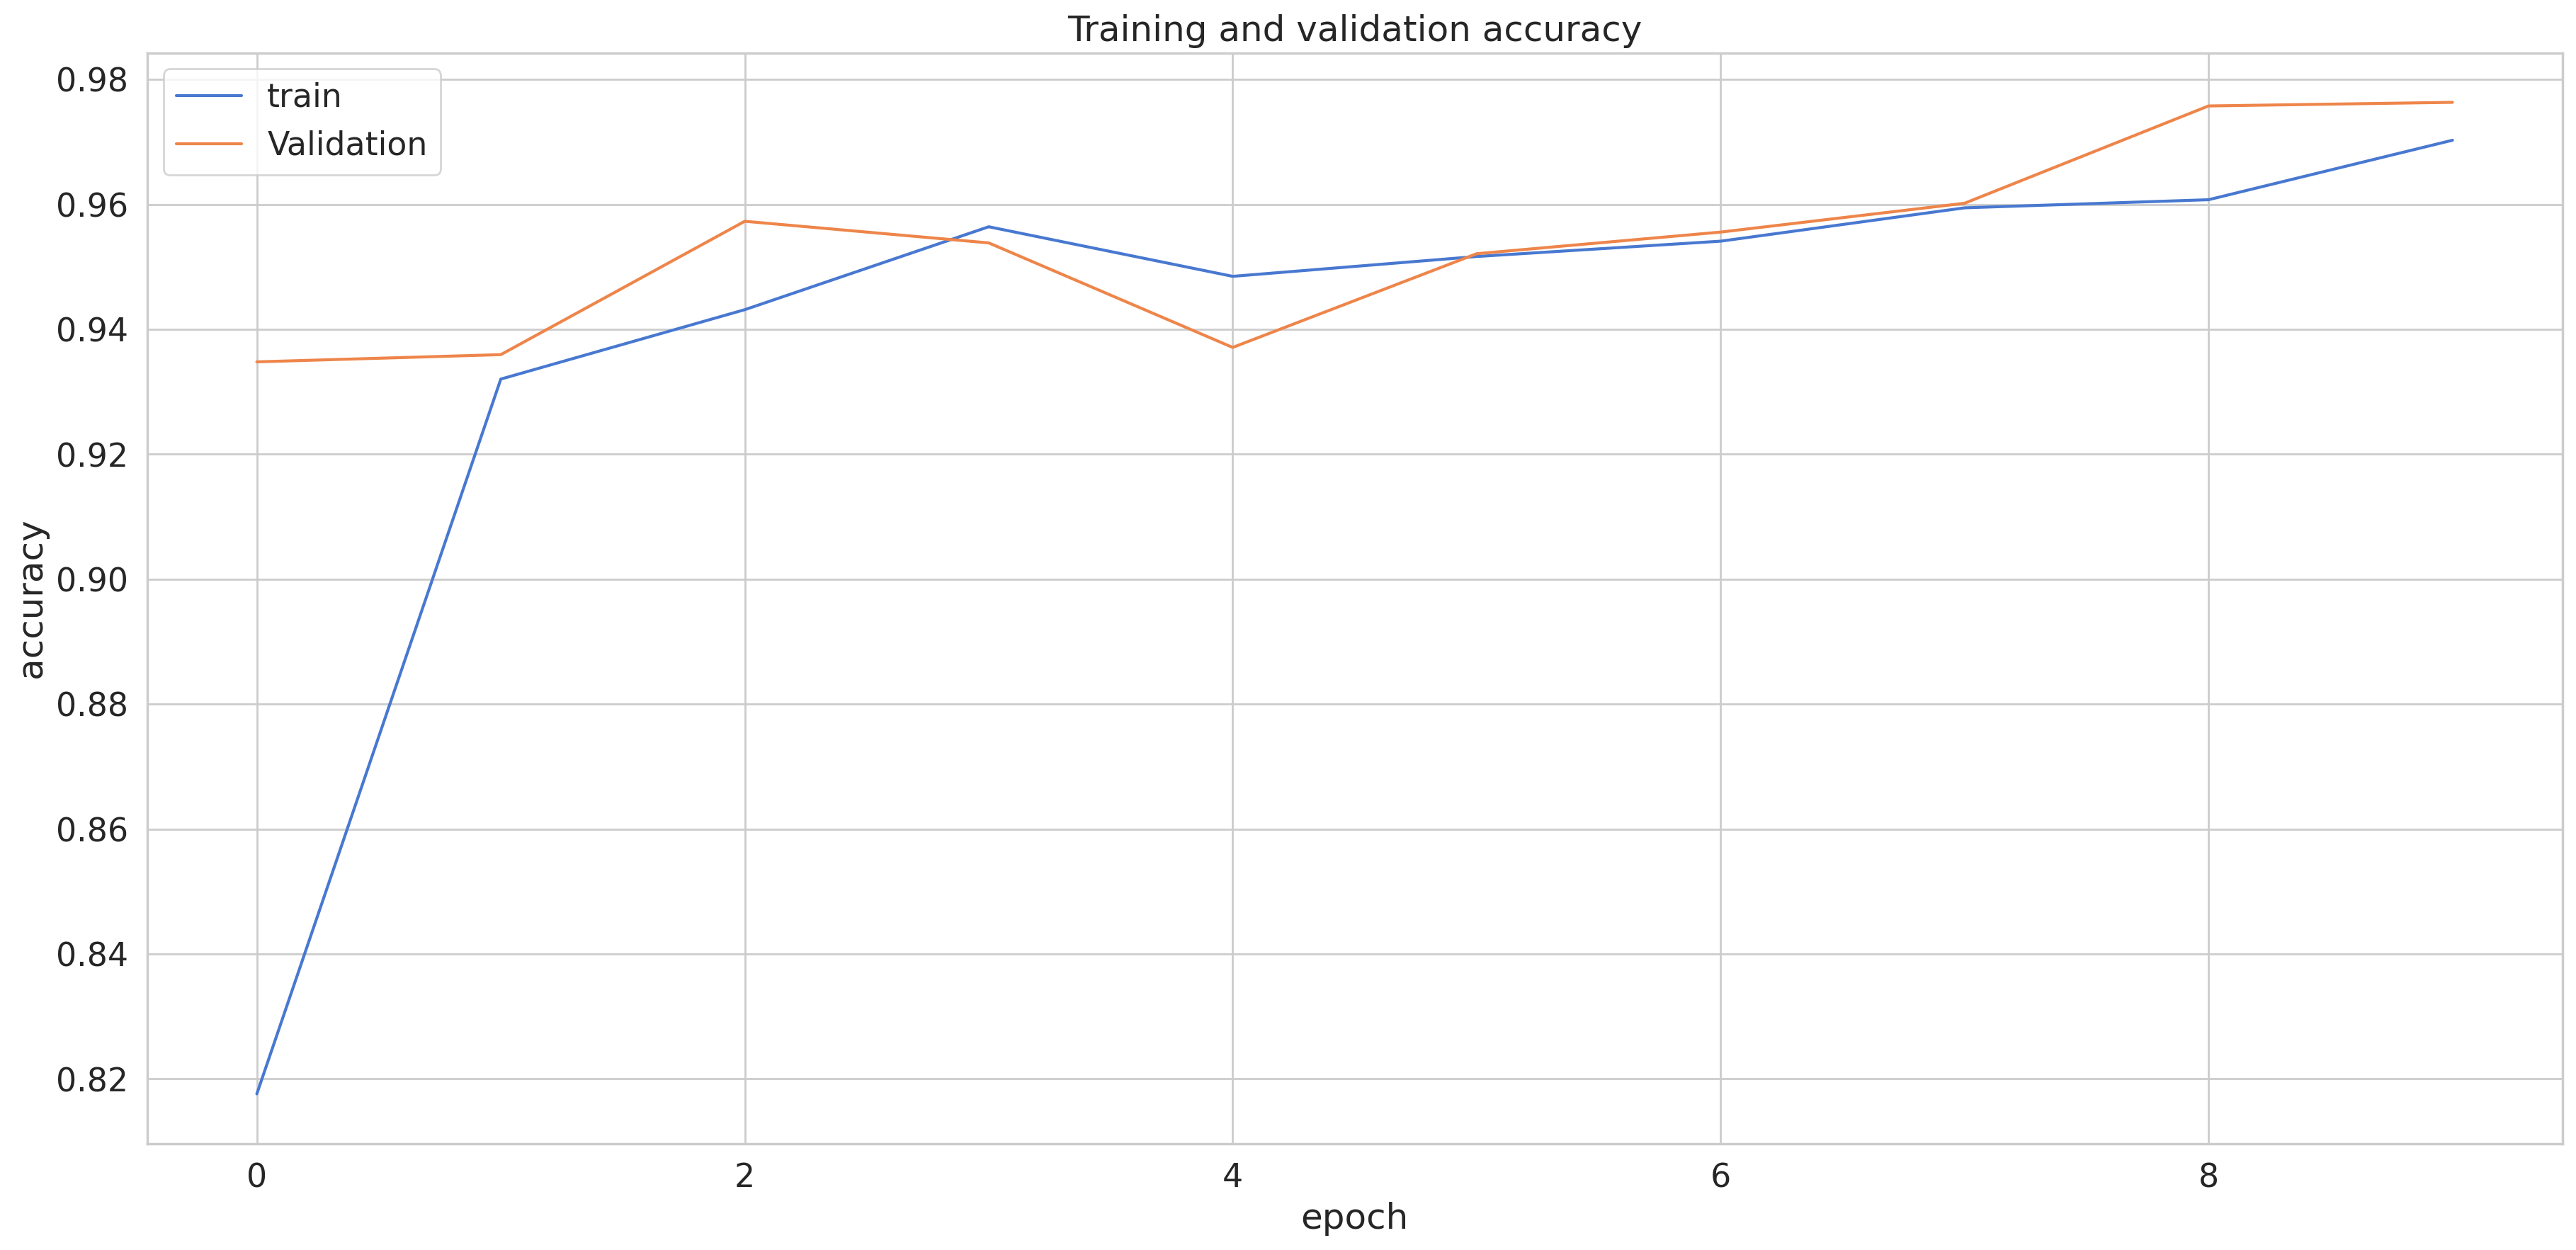

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 5ms/step
f1_score =  0.9728204917606627
0.9727608494921515
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1199
           1       0.94      1.00      0.97       967

    accuracy                           0.97      2166
   macro avg       0.97      0.98      0.97      2166
weighted avg       0.97      0.97      0.97      2166



<Axes: >

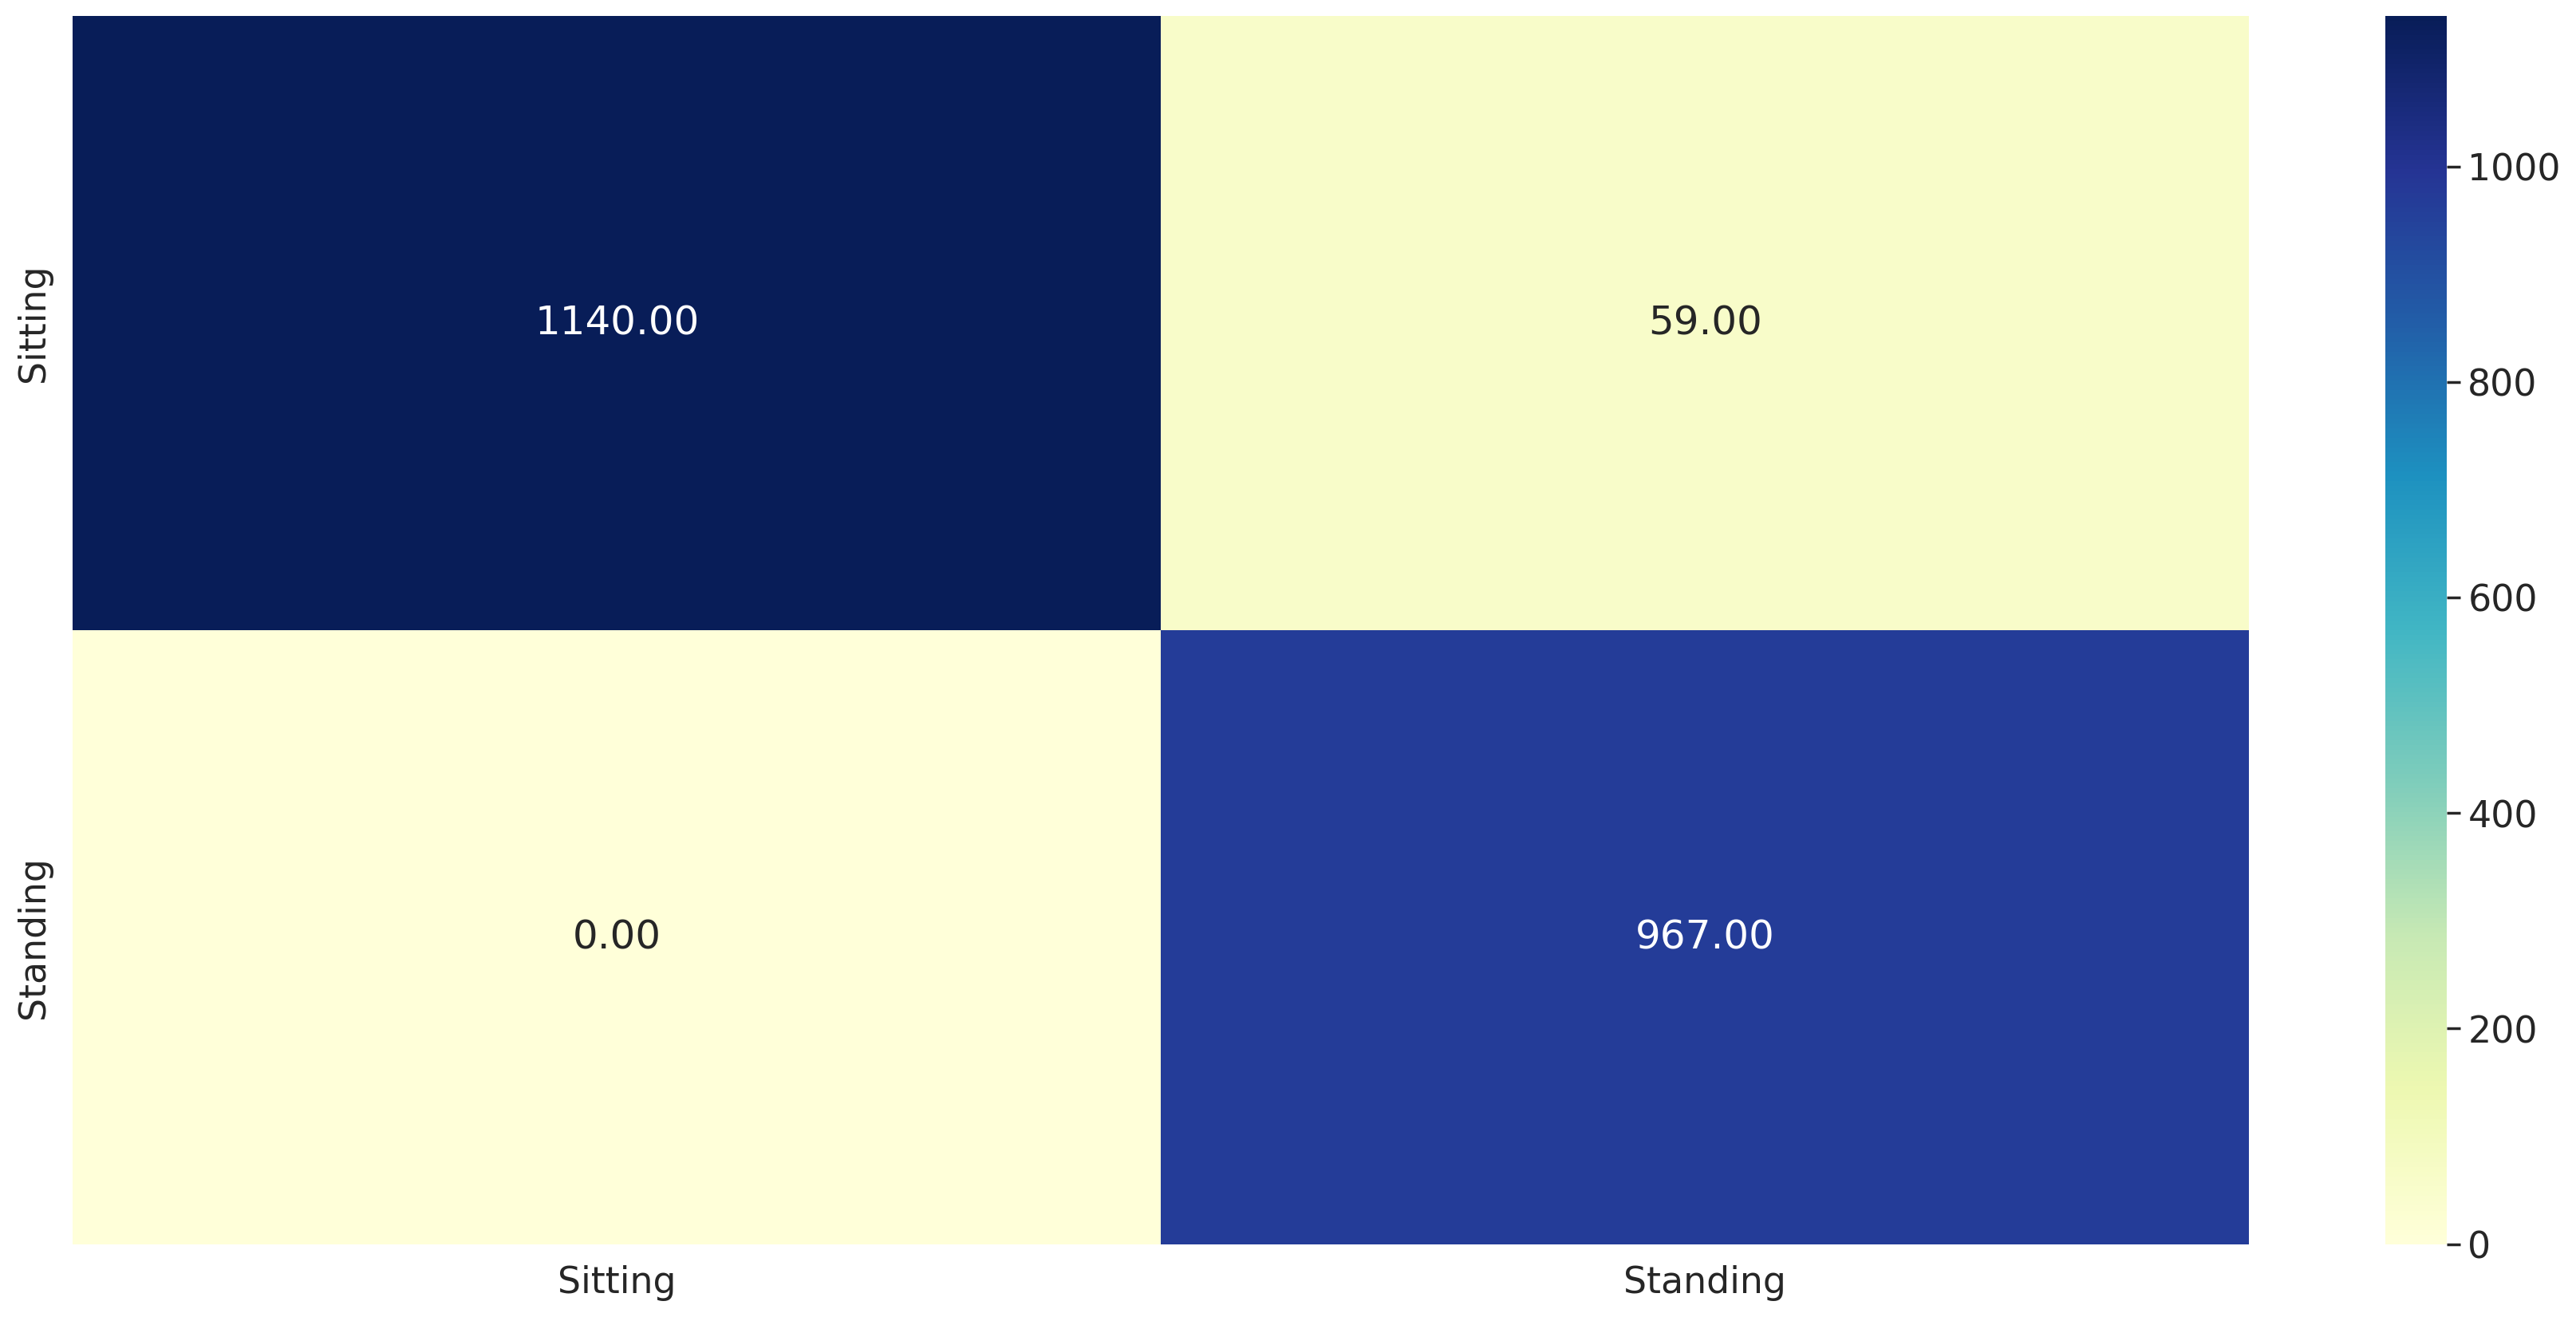

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [20]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 2)                

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 17s 88ms/step - loss: 0.1596 - accuracy: 0.9388 - val_loss: 0.0954 - val_accuracy: 0.9723
Epoch 2/10
55/55 [==============================] - 1s 23ms/step - loss: 0.1080 - accuracy: 0.9623 - val_loss: 0.1081 - val_accuracy: 0.9706
Epoch 3/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0908 - accuracy: 0.9723 - val_loss: 0.0749 - val_accuracy: 0.9752
Epoch 4/10
55/55 [==============================] - 1s 20ms/step - loss: 0.0780 - accuracy: 0.9719 - val_loss: 0.0682 - val_accuracy: 0.9740
Epoch 5/10
55/55 [==============================] - 1s 20ms/step - loss: 0.0810 - accuracy: 0.9722 - val_loss: 0.0843 - val_accuracy: 0.9752
Epoch 6/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0731 - accuracy: 0.9723 - val_loss: 0.0864 - val_accuracy: 0.9746
Epoch 7/10
55/55 [==============================] - 1s 19ms/step - loss: 0.0789 - accuracy: 0.9724 - val_loss: 0.0531 - val_accuracy: 0.9908
Epoch 8/10
5

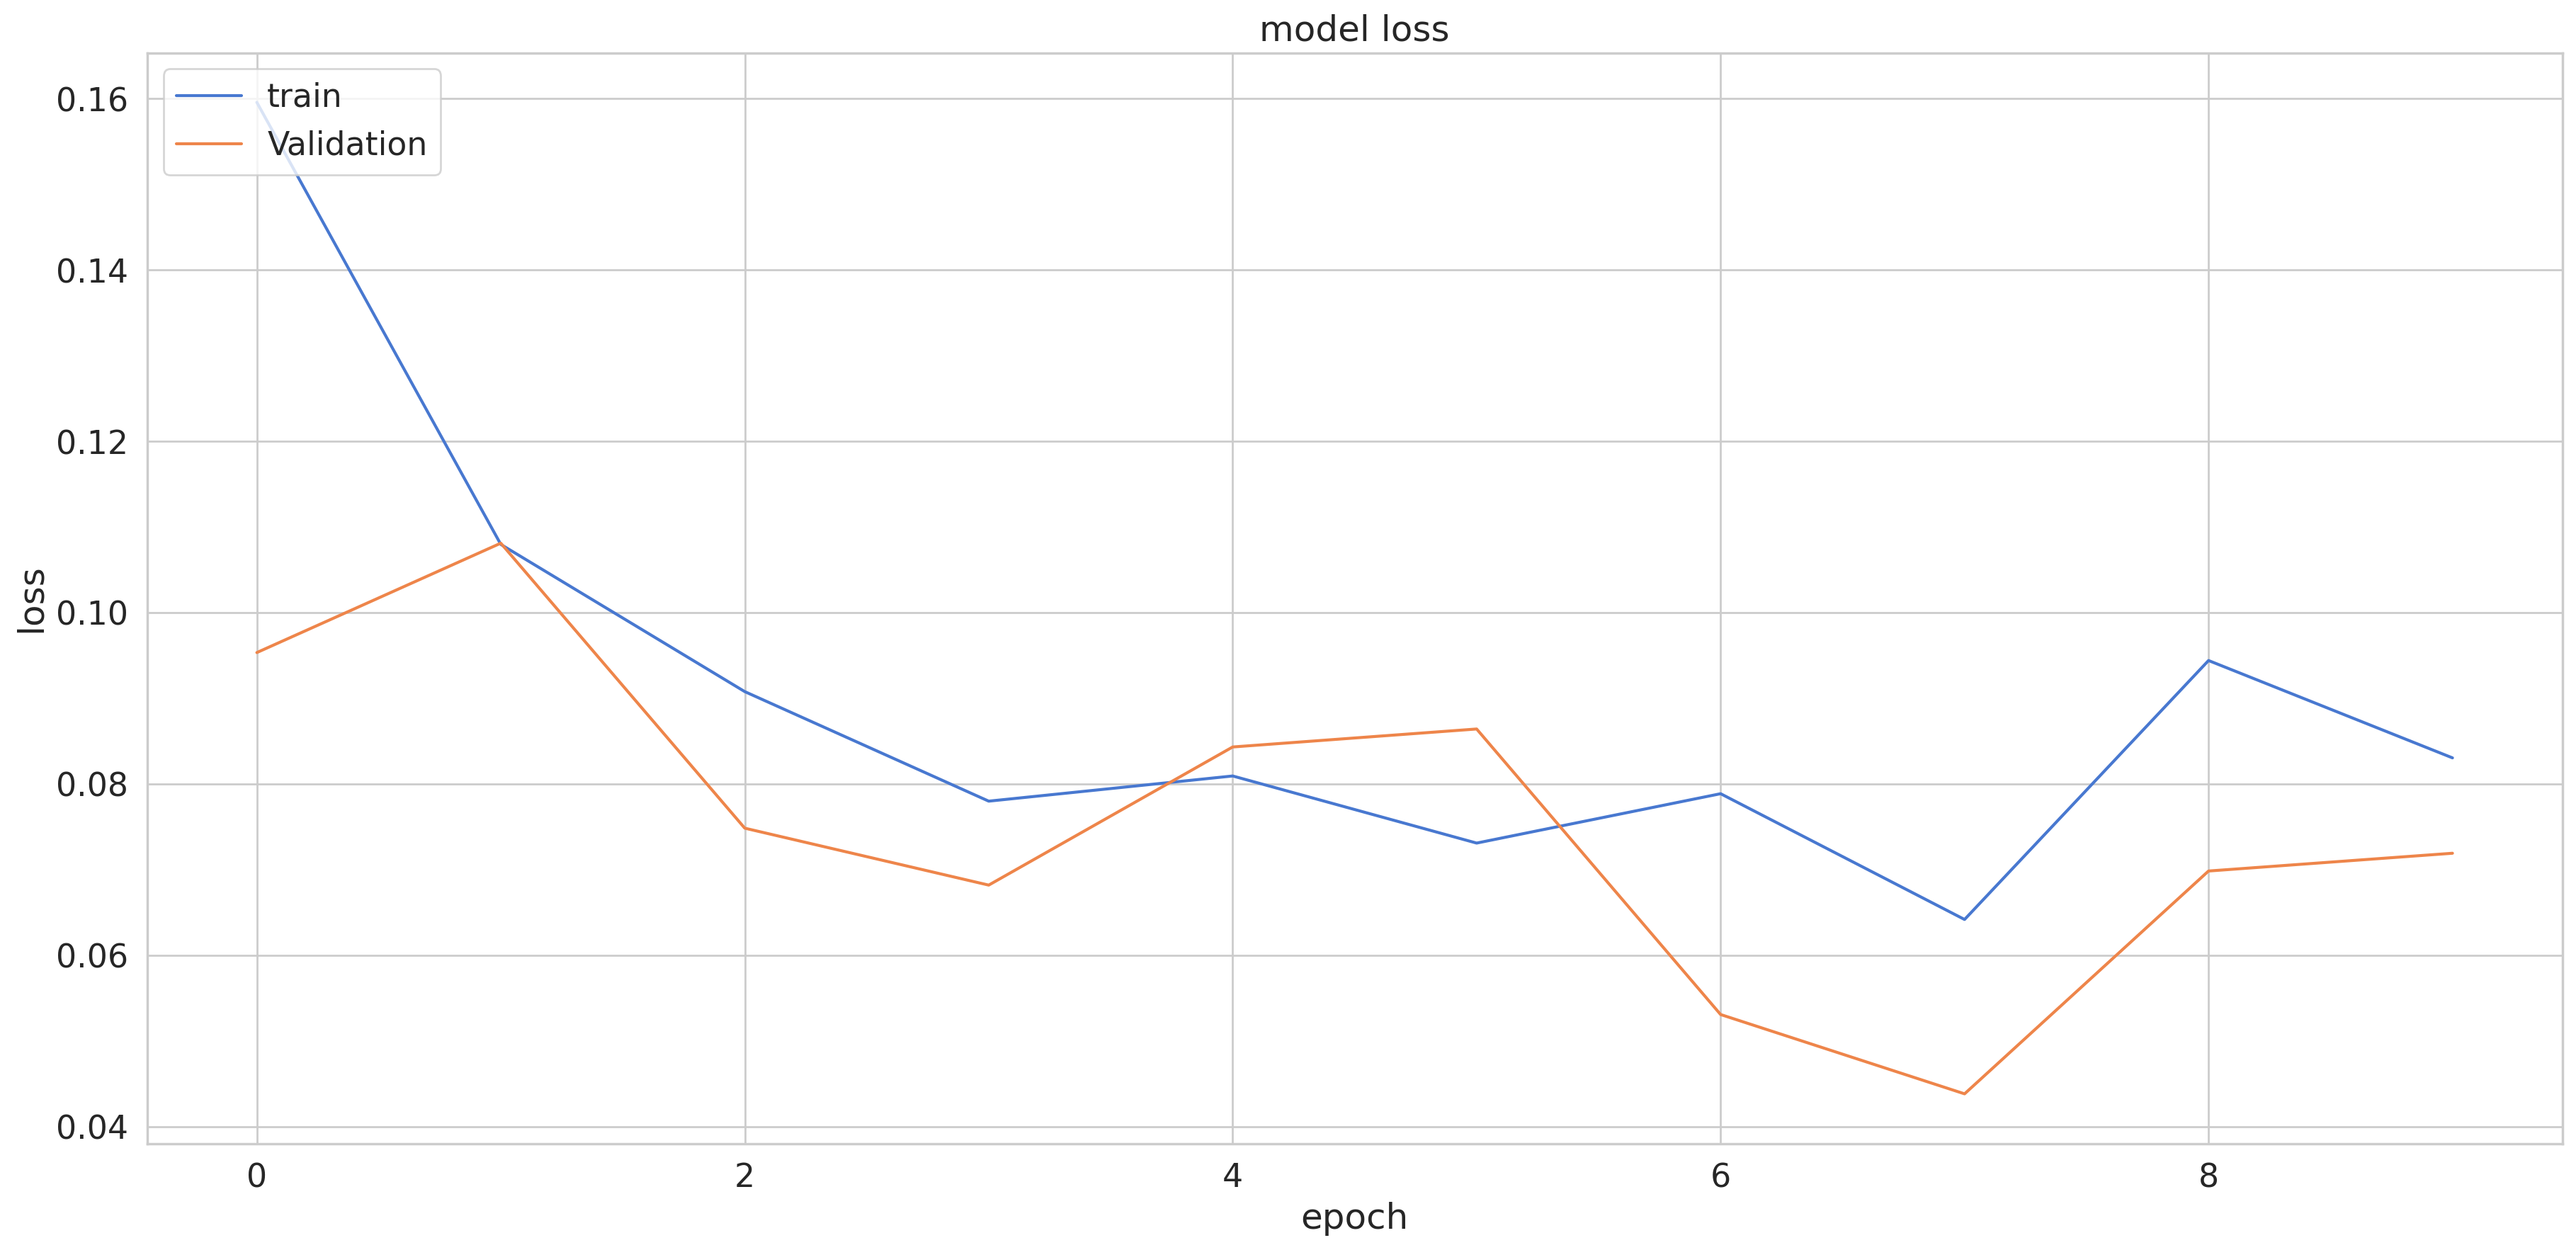

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

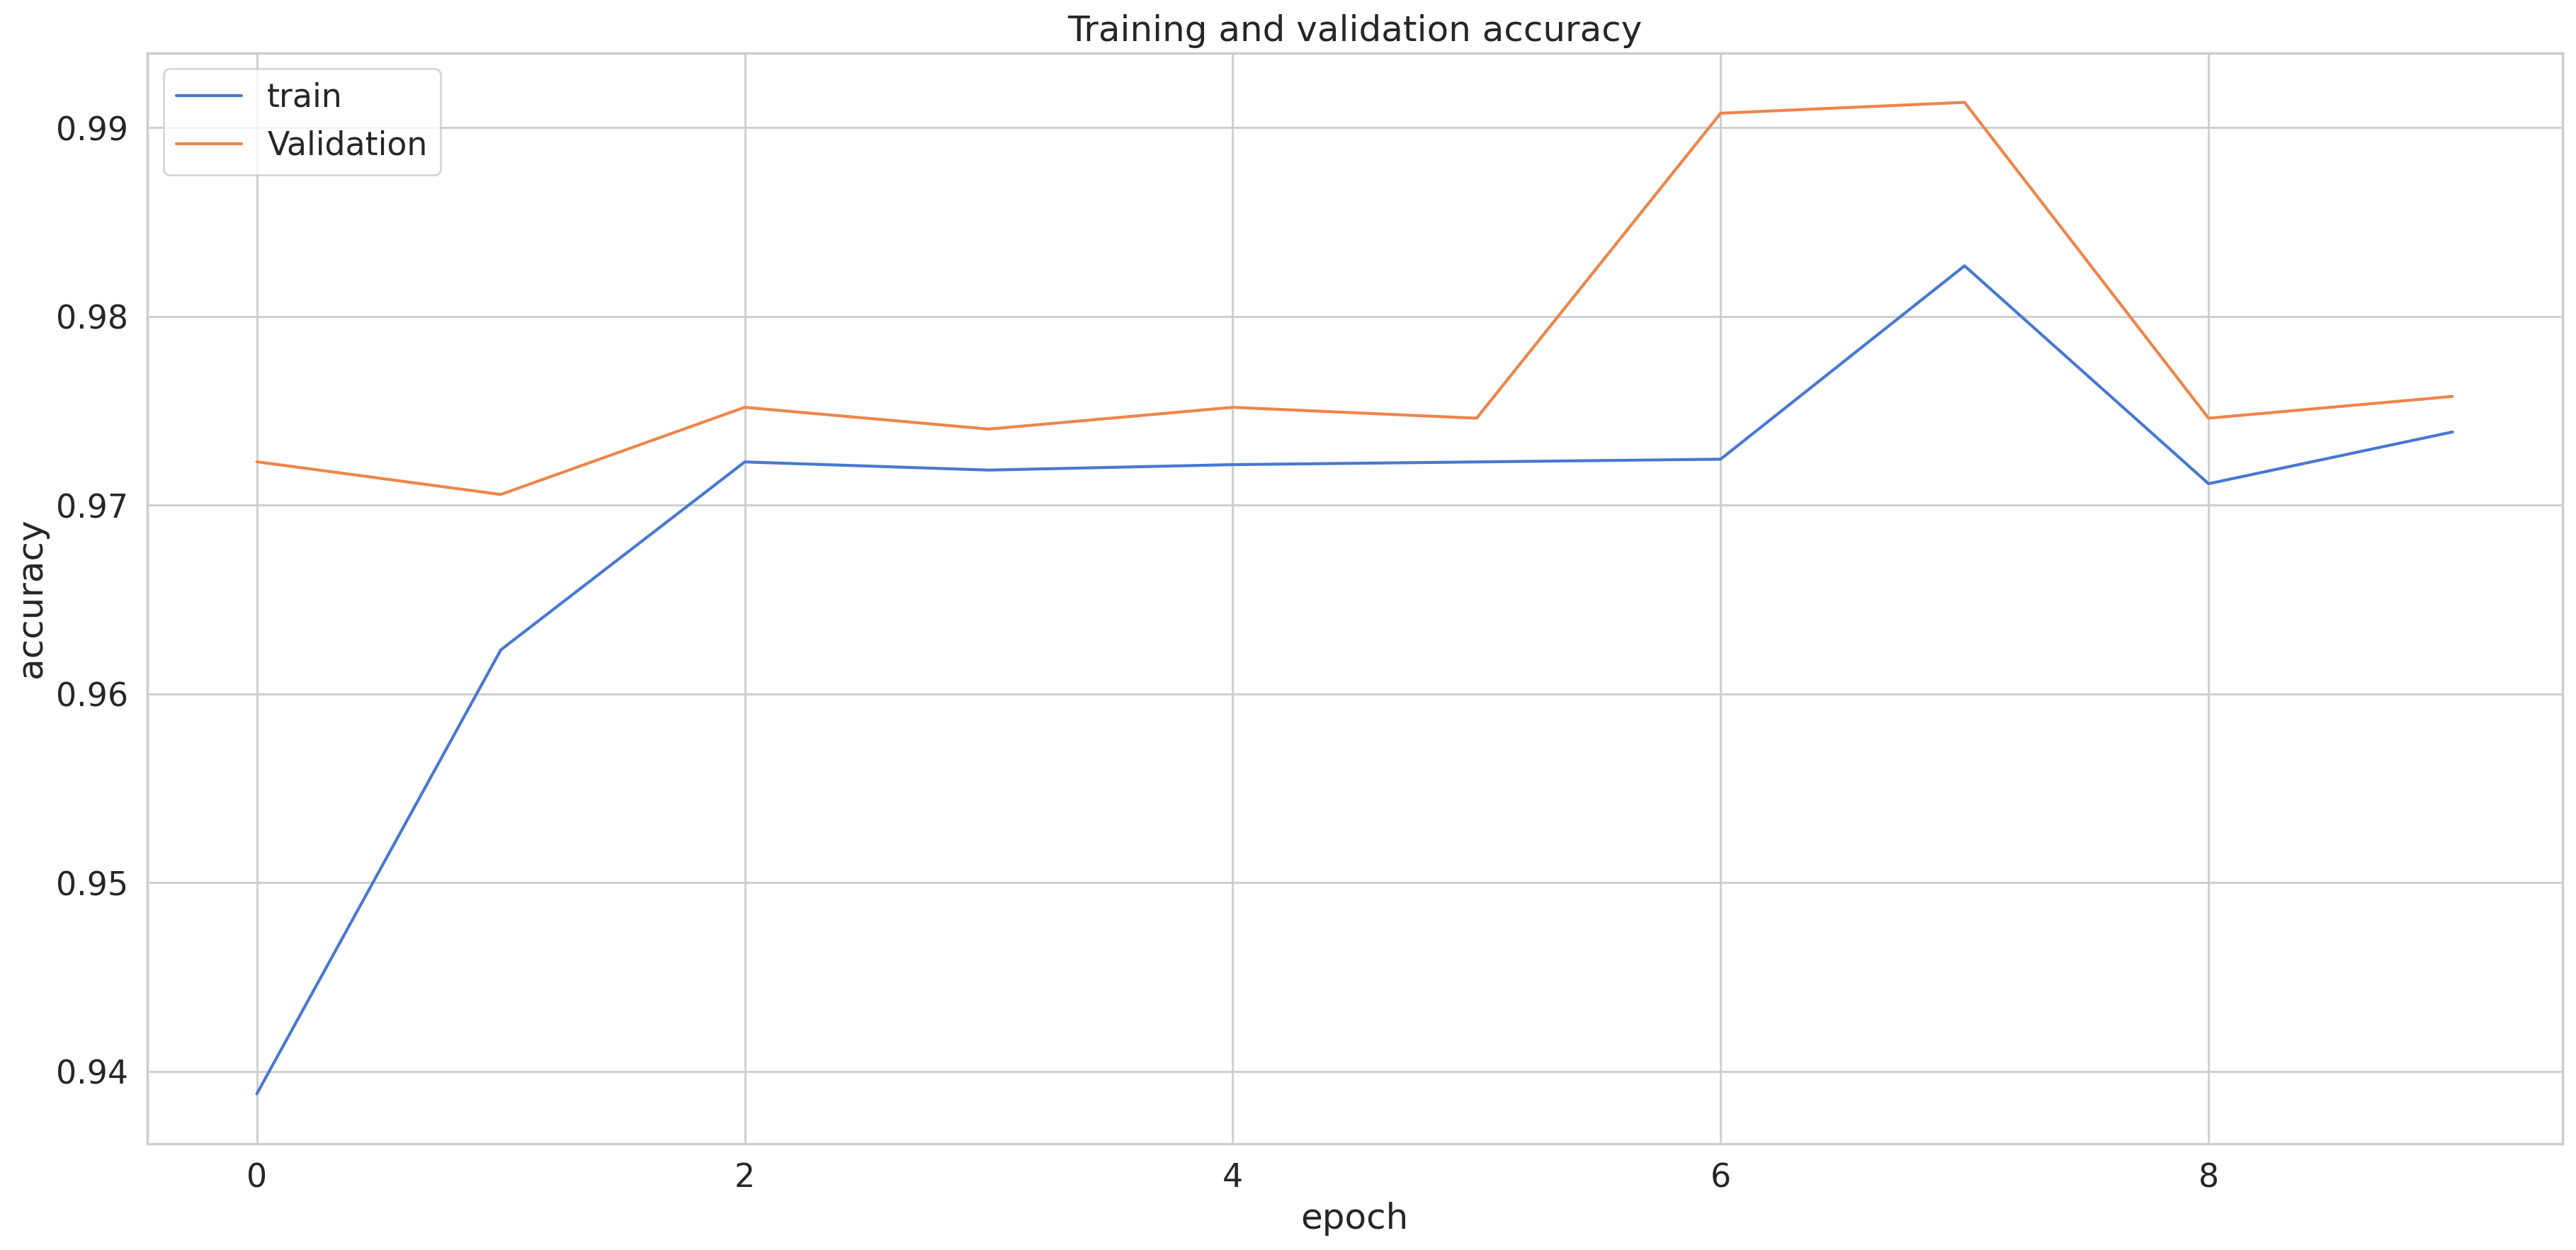

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 2s 7ms/step
f1_score =  0.9728191448254907
0.9727608494921515
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1199
           1       0.94      1.00      0.97       967

    accuracy                           0.97      2166
   macro avg       0.97      0.98      0.97      2166
weighted avg       0.97      0.97      0.97      2166



<Axes: >

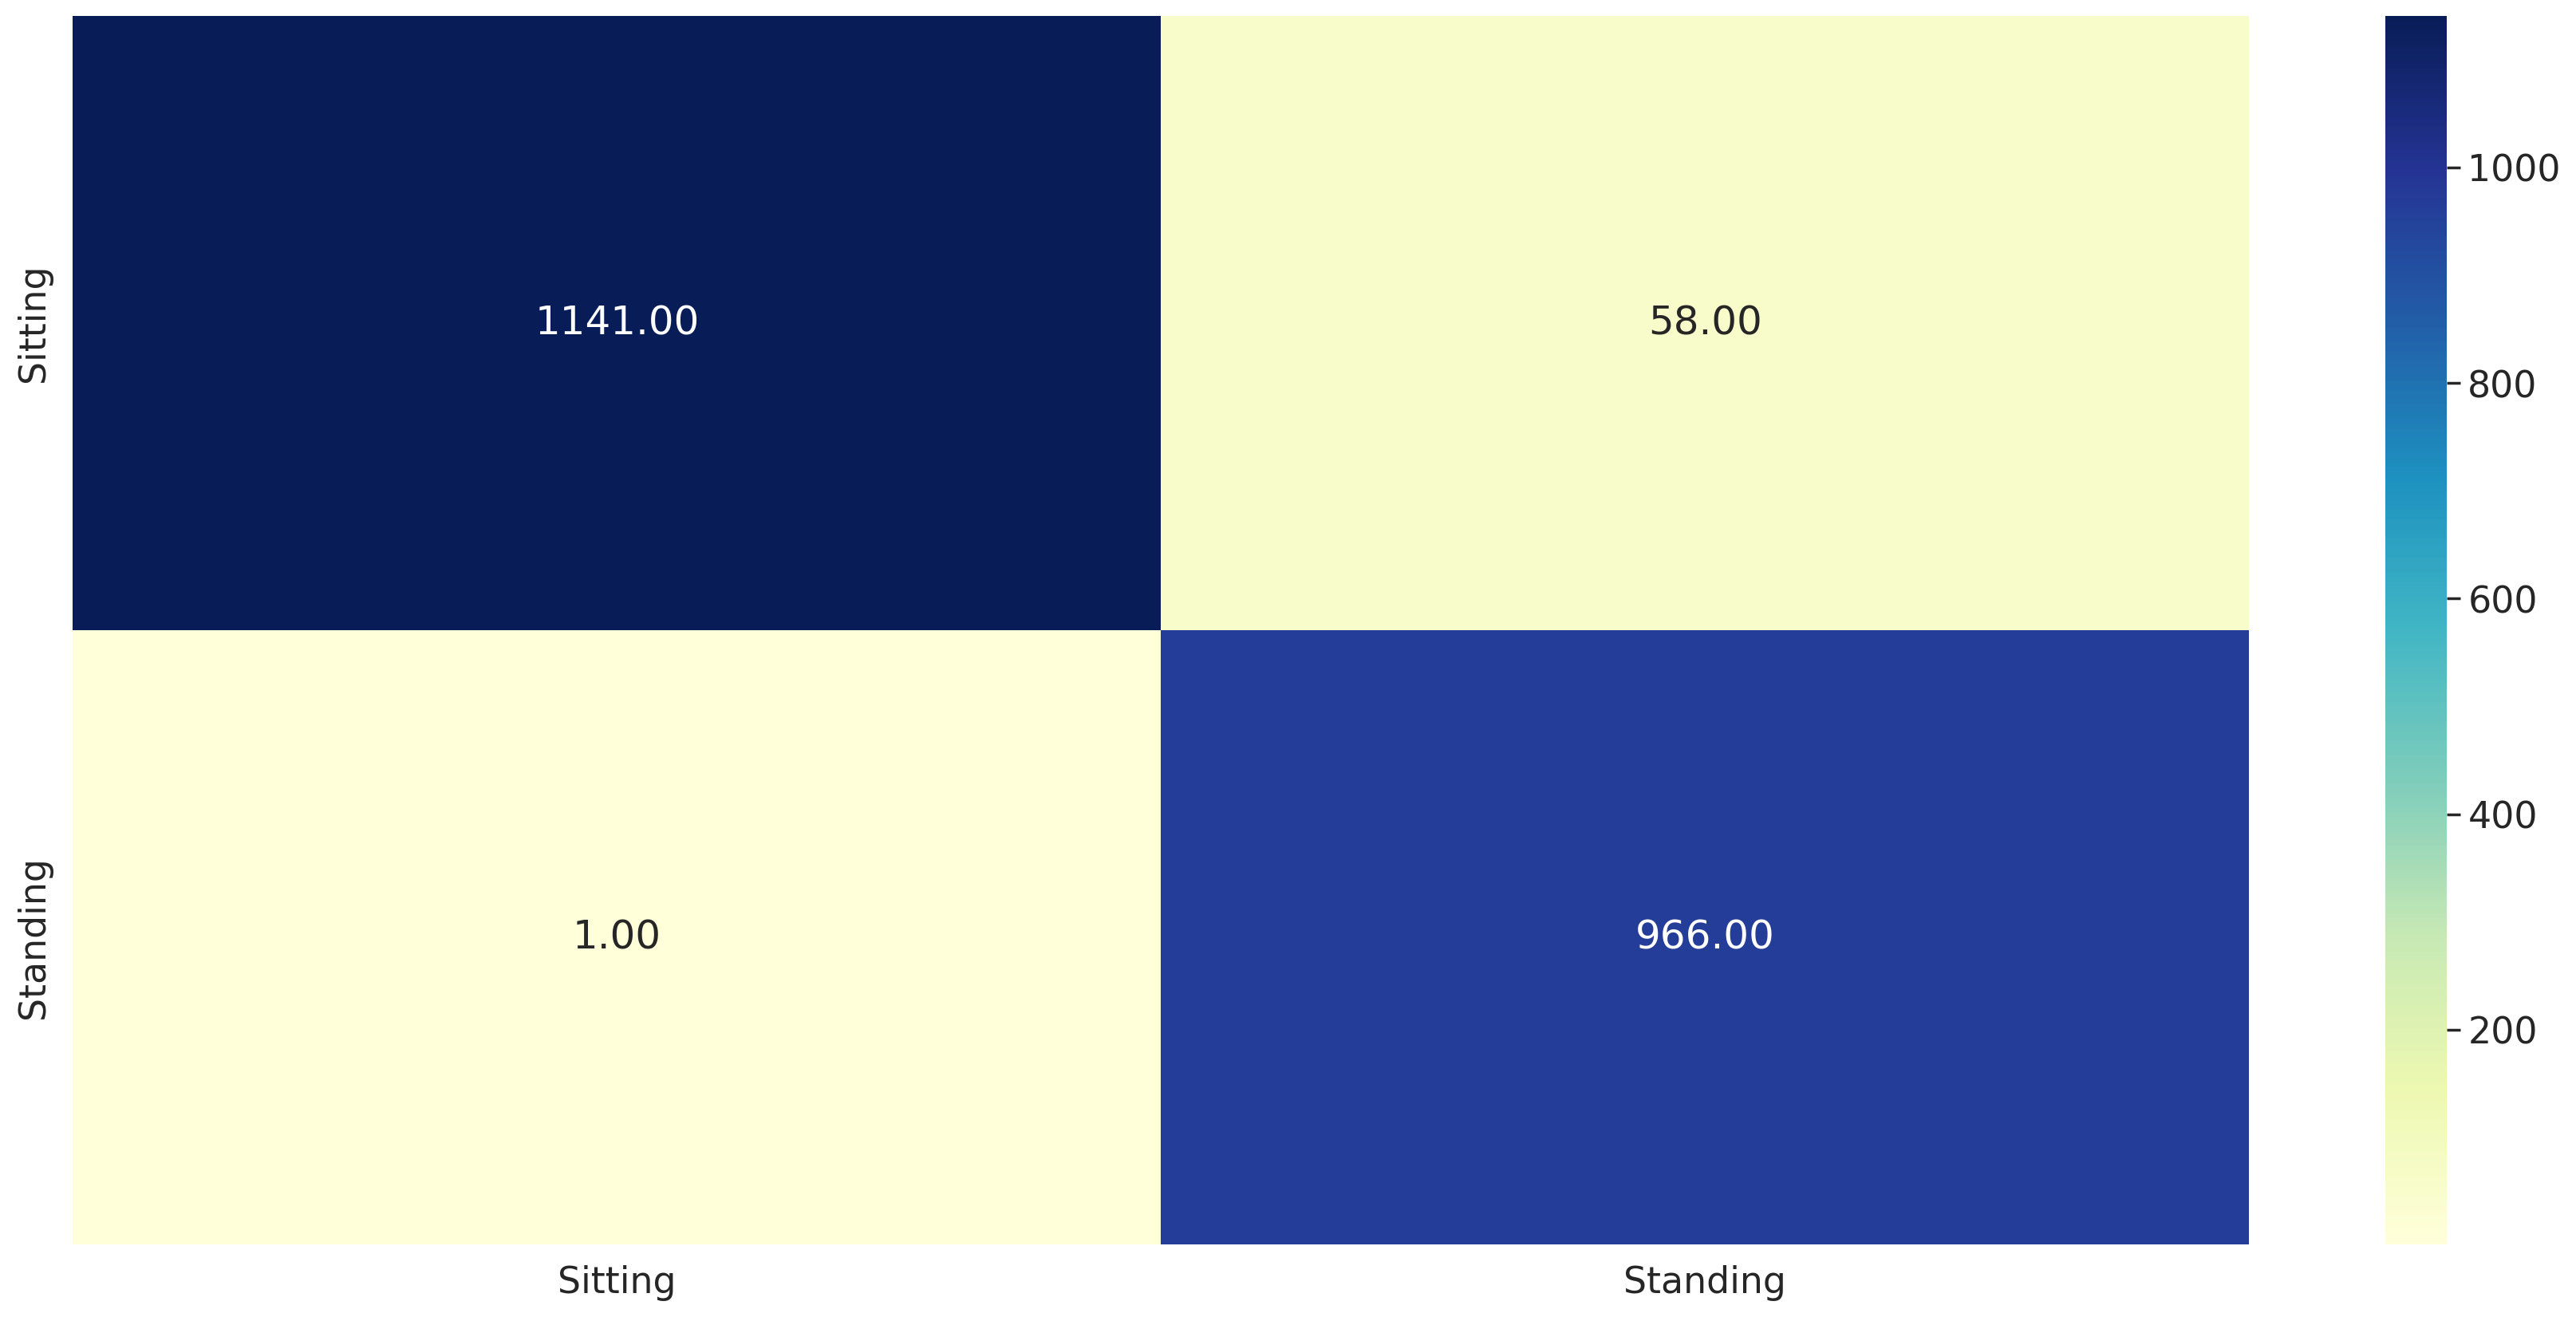

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [25]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                      

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 17s 90ms/step - loss: 0.1467 - accuracy: 0.9479 - val_loss: 0.0910 - val_accuracy: 0.9740
Epoch 2/10
55/55 [==============================] - 2s 33ms/step - loss: 0.0873 - accuracy: 0.9719 - val_loss: 0.0892 - val_accuracy: 0.9735
Epoch 3/10
55/55 [==============================] - 2s 30ms/step - loss: 0.0885 - accuracy: 0.9693 - val_loss: 0.0553 - val_accuracy: 0.9746
Epoch 4/10
55/55 [==============================] - 2s 35ms/step - loss: 0.0577 - accuracy: 0.9820 - val_loss: 0.0450 - val_accuracy: 0.9902
Epoch 5/10
55/55 [==============================] - 2s 33ms/step - loss: 0.0488 - accuracy: 0.9892 - val_loss: 0.1185 - val_accuracy: 0.9688
Epoch 6/10
55/55 [==============================] - 2s 33ms/step - loss: 0.0705 - accuracy: 0.9791 - val_loss: 0.0386 - val_accuracy: 0.9925
Epoch 7/10
55/55 [==============================] - 2s 33ms/step - loss: 0.0694 - accuracy: 0.9824 - val_loss: 0.0546 - val_accuracy: 0.9844
Epoch 8/10
5

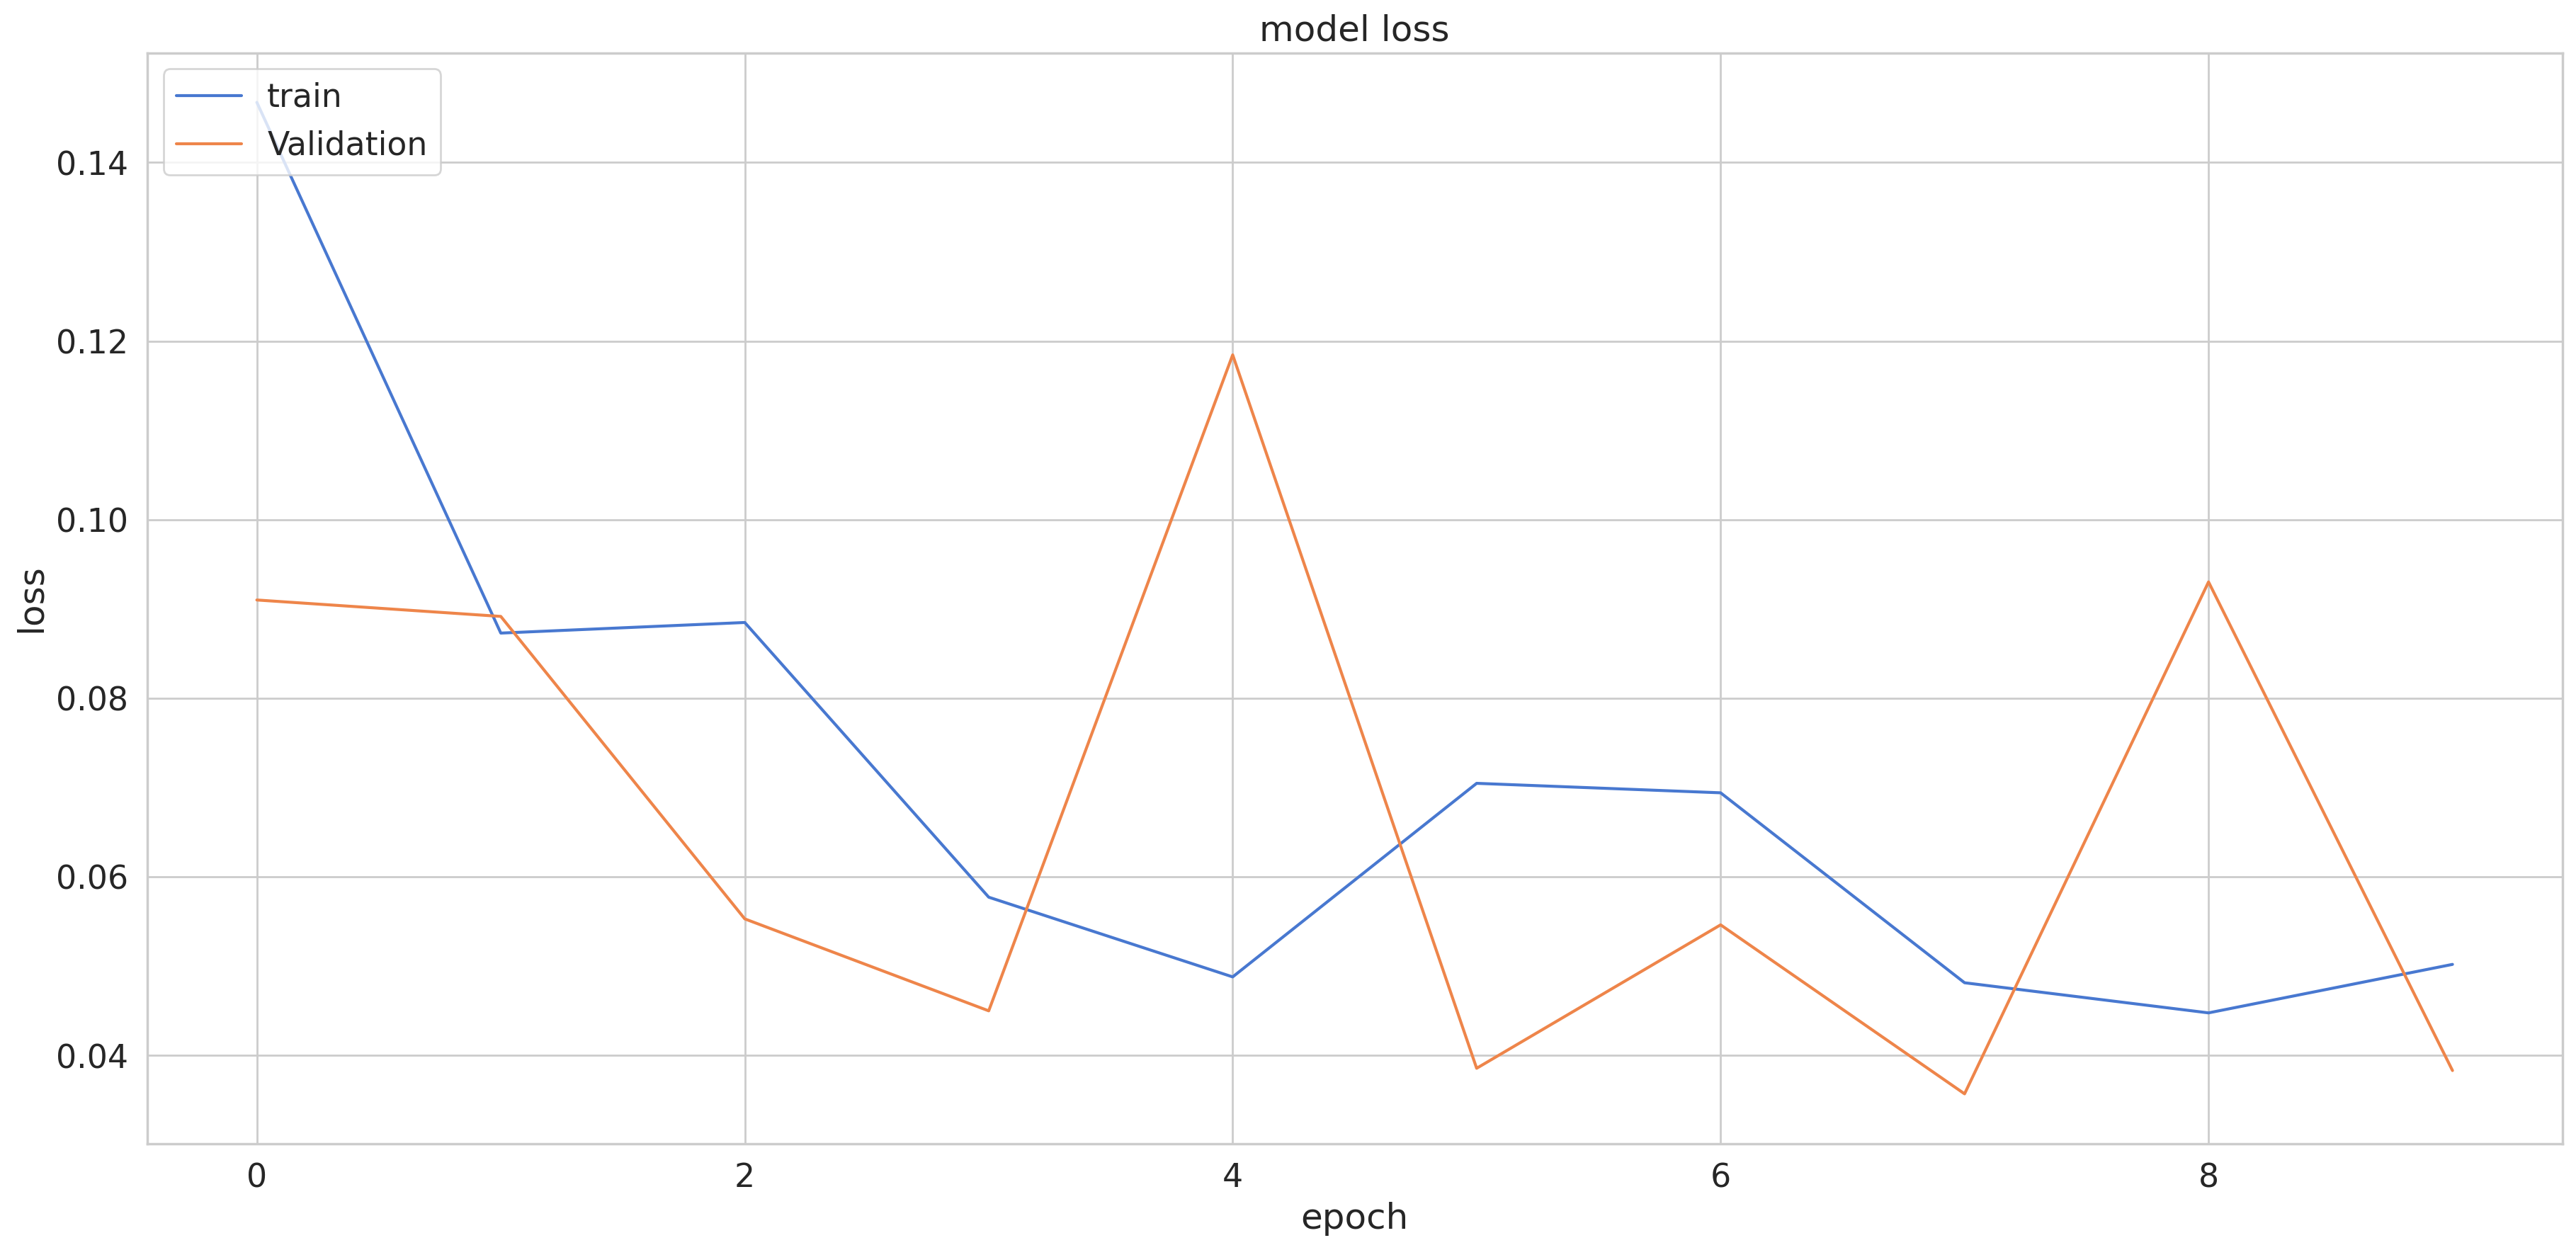

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

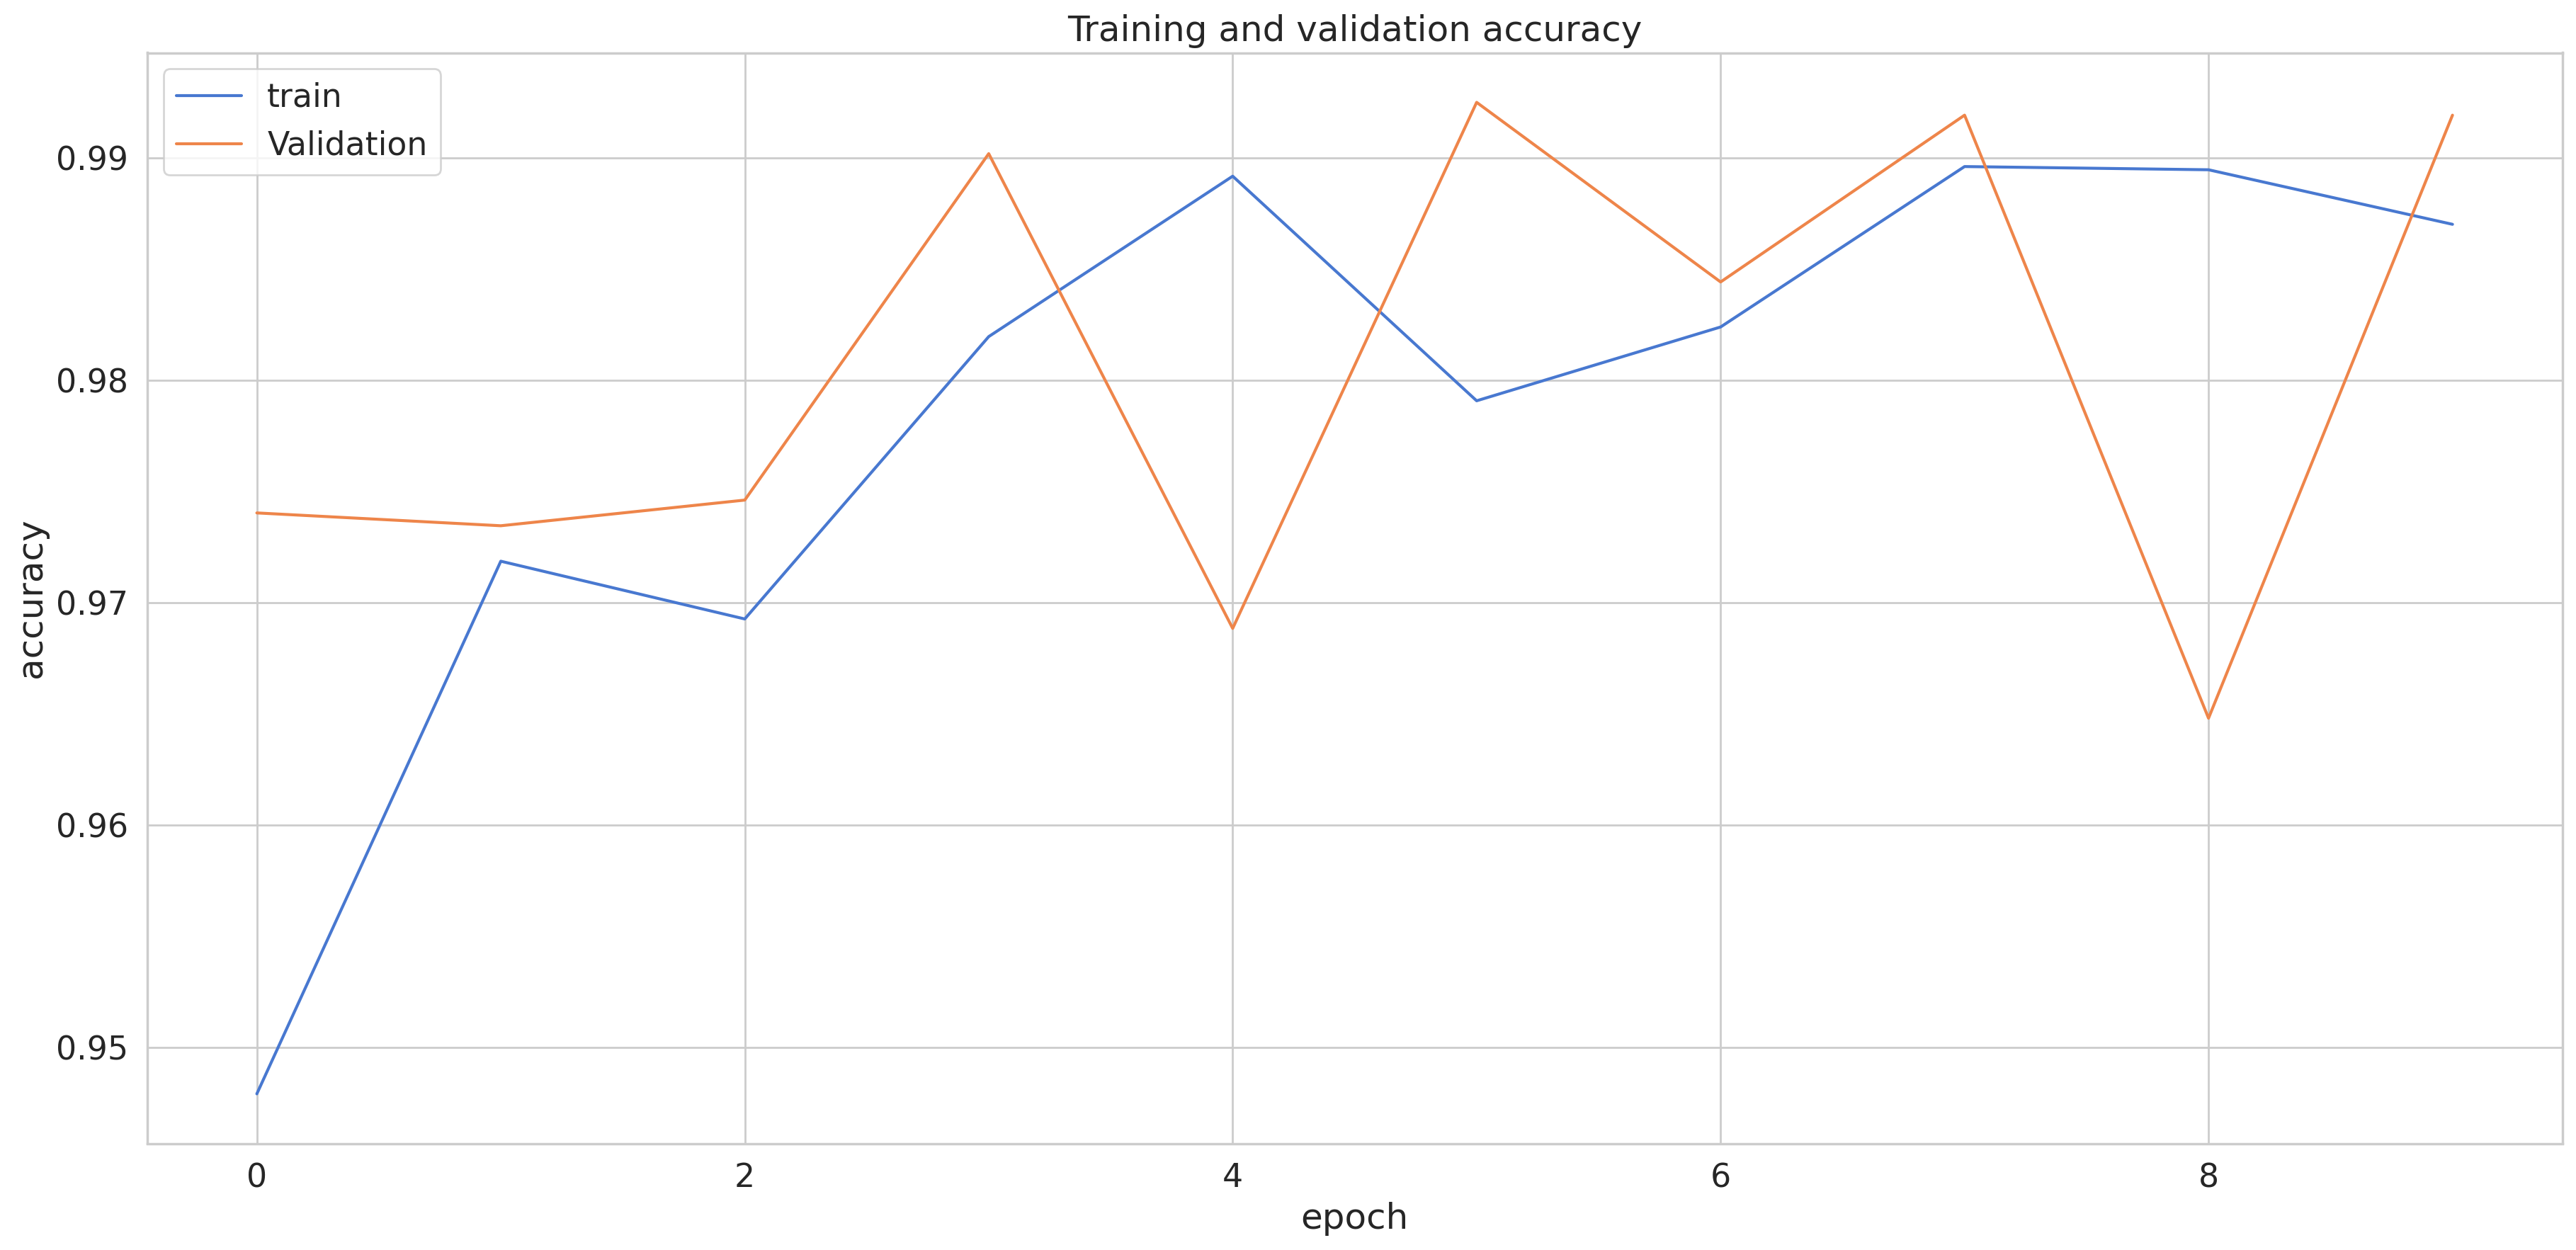

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 3s 11ms/step
f1_score =  0.99676902690421
0.9967682363804248
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1199
           1       0.99      1.00      1.00       967

    accuracy                           1.00      2166
   macro avg       1.00      1.00      1.00      2166
weighted avg       1.00      1.00      1.00      2166



<Axes: >

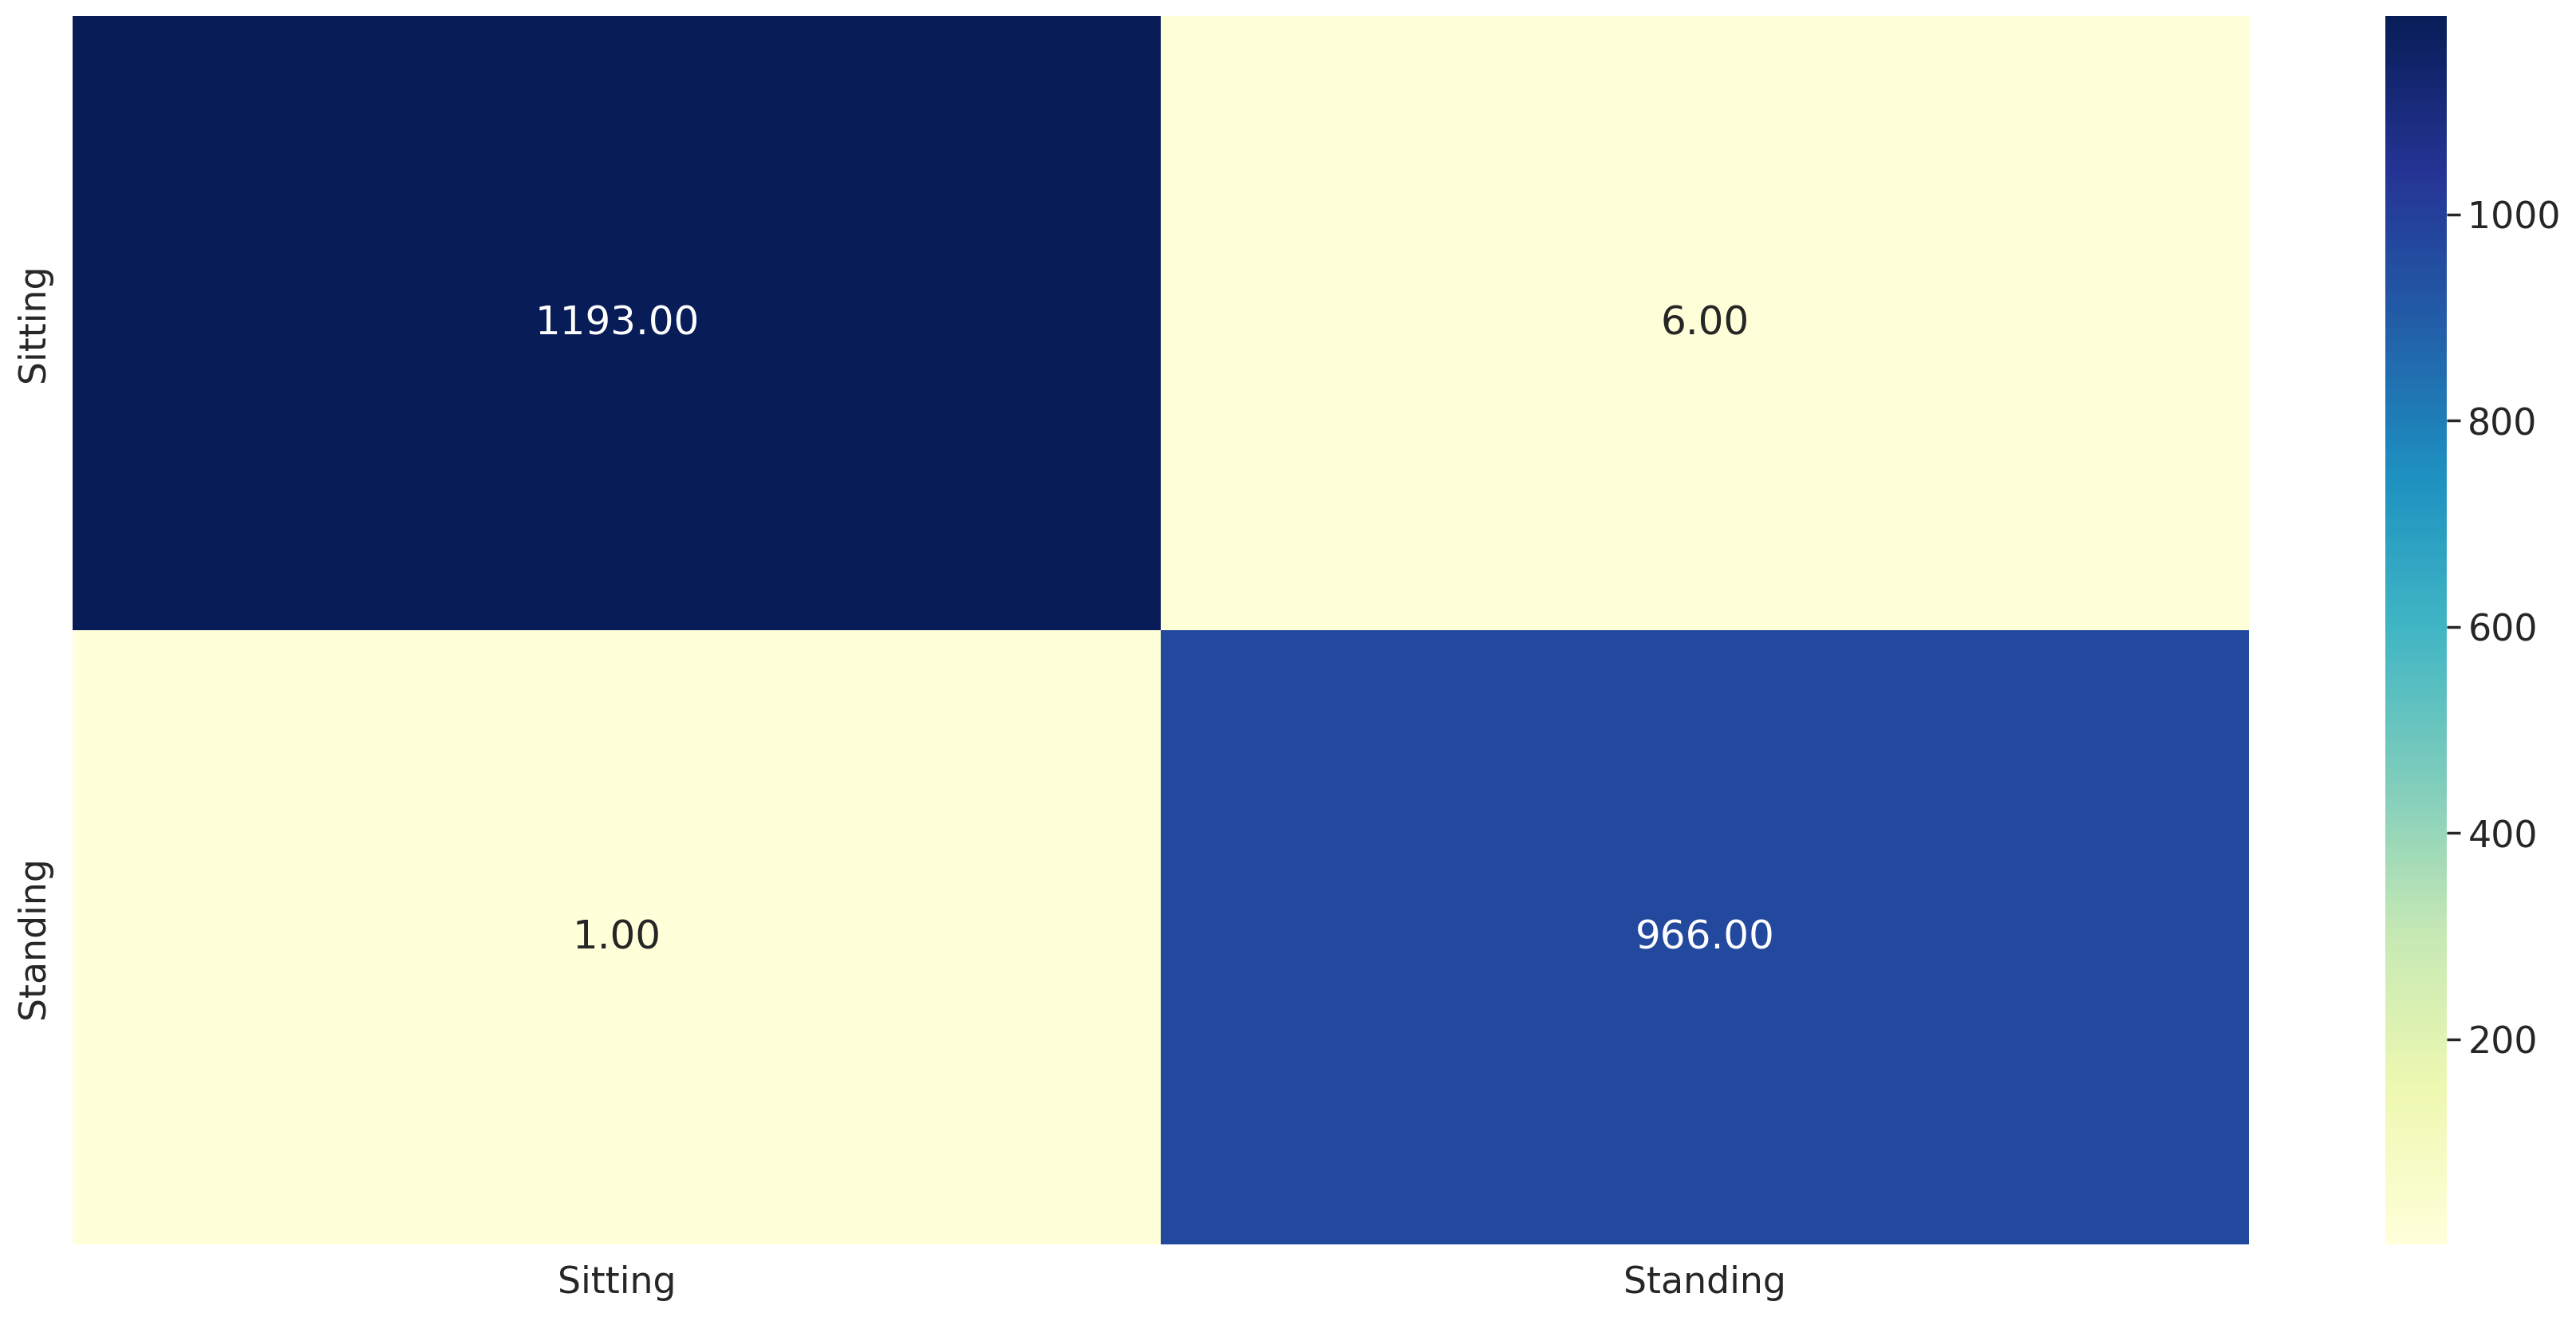

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [30]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 50, 256)           135168    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 50, 256)           394240    
 onal)                                                           
                                                      

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 19s 87ms/step - loss: 0.1496 - accuracy: 0.9434 - val_loss: 0.0892 - val_accuracy: 0.9423
Epoch 2/10
55/55 [==============================] - 2s 42ms/step - loss: 0.1039 - accuracy: 0.9543 - val_loss: 0.1349 - val_accuracy: 0.9521
Epoch 3/10
55/55 [==============================] - 2s 40ms/step - loss: 0.1050 - accuracy: 0.9563 - val_loss: 0.0959 - val_accuracy: 0.9596
Epoch 4/10
55/55 [==============================] - 2s 42ms/step - loss: 0.1117 - accuracy: 0.9553 - val_loss: 0.1017 - val_accuracy: 0.9602
Epoch 5/10
55/55 [==============================] - 3s 62ms/step - loss: 0.0963 - accuracy: 0.9612 - val_loss: 0.1125 - val_accuracy: 0.9596
Epoch 6/10
55/55 [==============================] - 2s 40ms/step - loss: 0.1072 - accuracy: 0.9584 - val_loss: 0.0811 - val_accuracy: 0.9752
Epoch 7/10
55/55 [==============================] - 2s 40ms/step - loss: 0.0947 - accuracy: 0.9693 - val_loss: 0.0758 - val_accuracy: 0.9752
Epoch 8/10
5

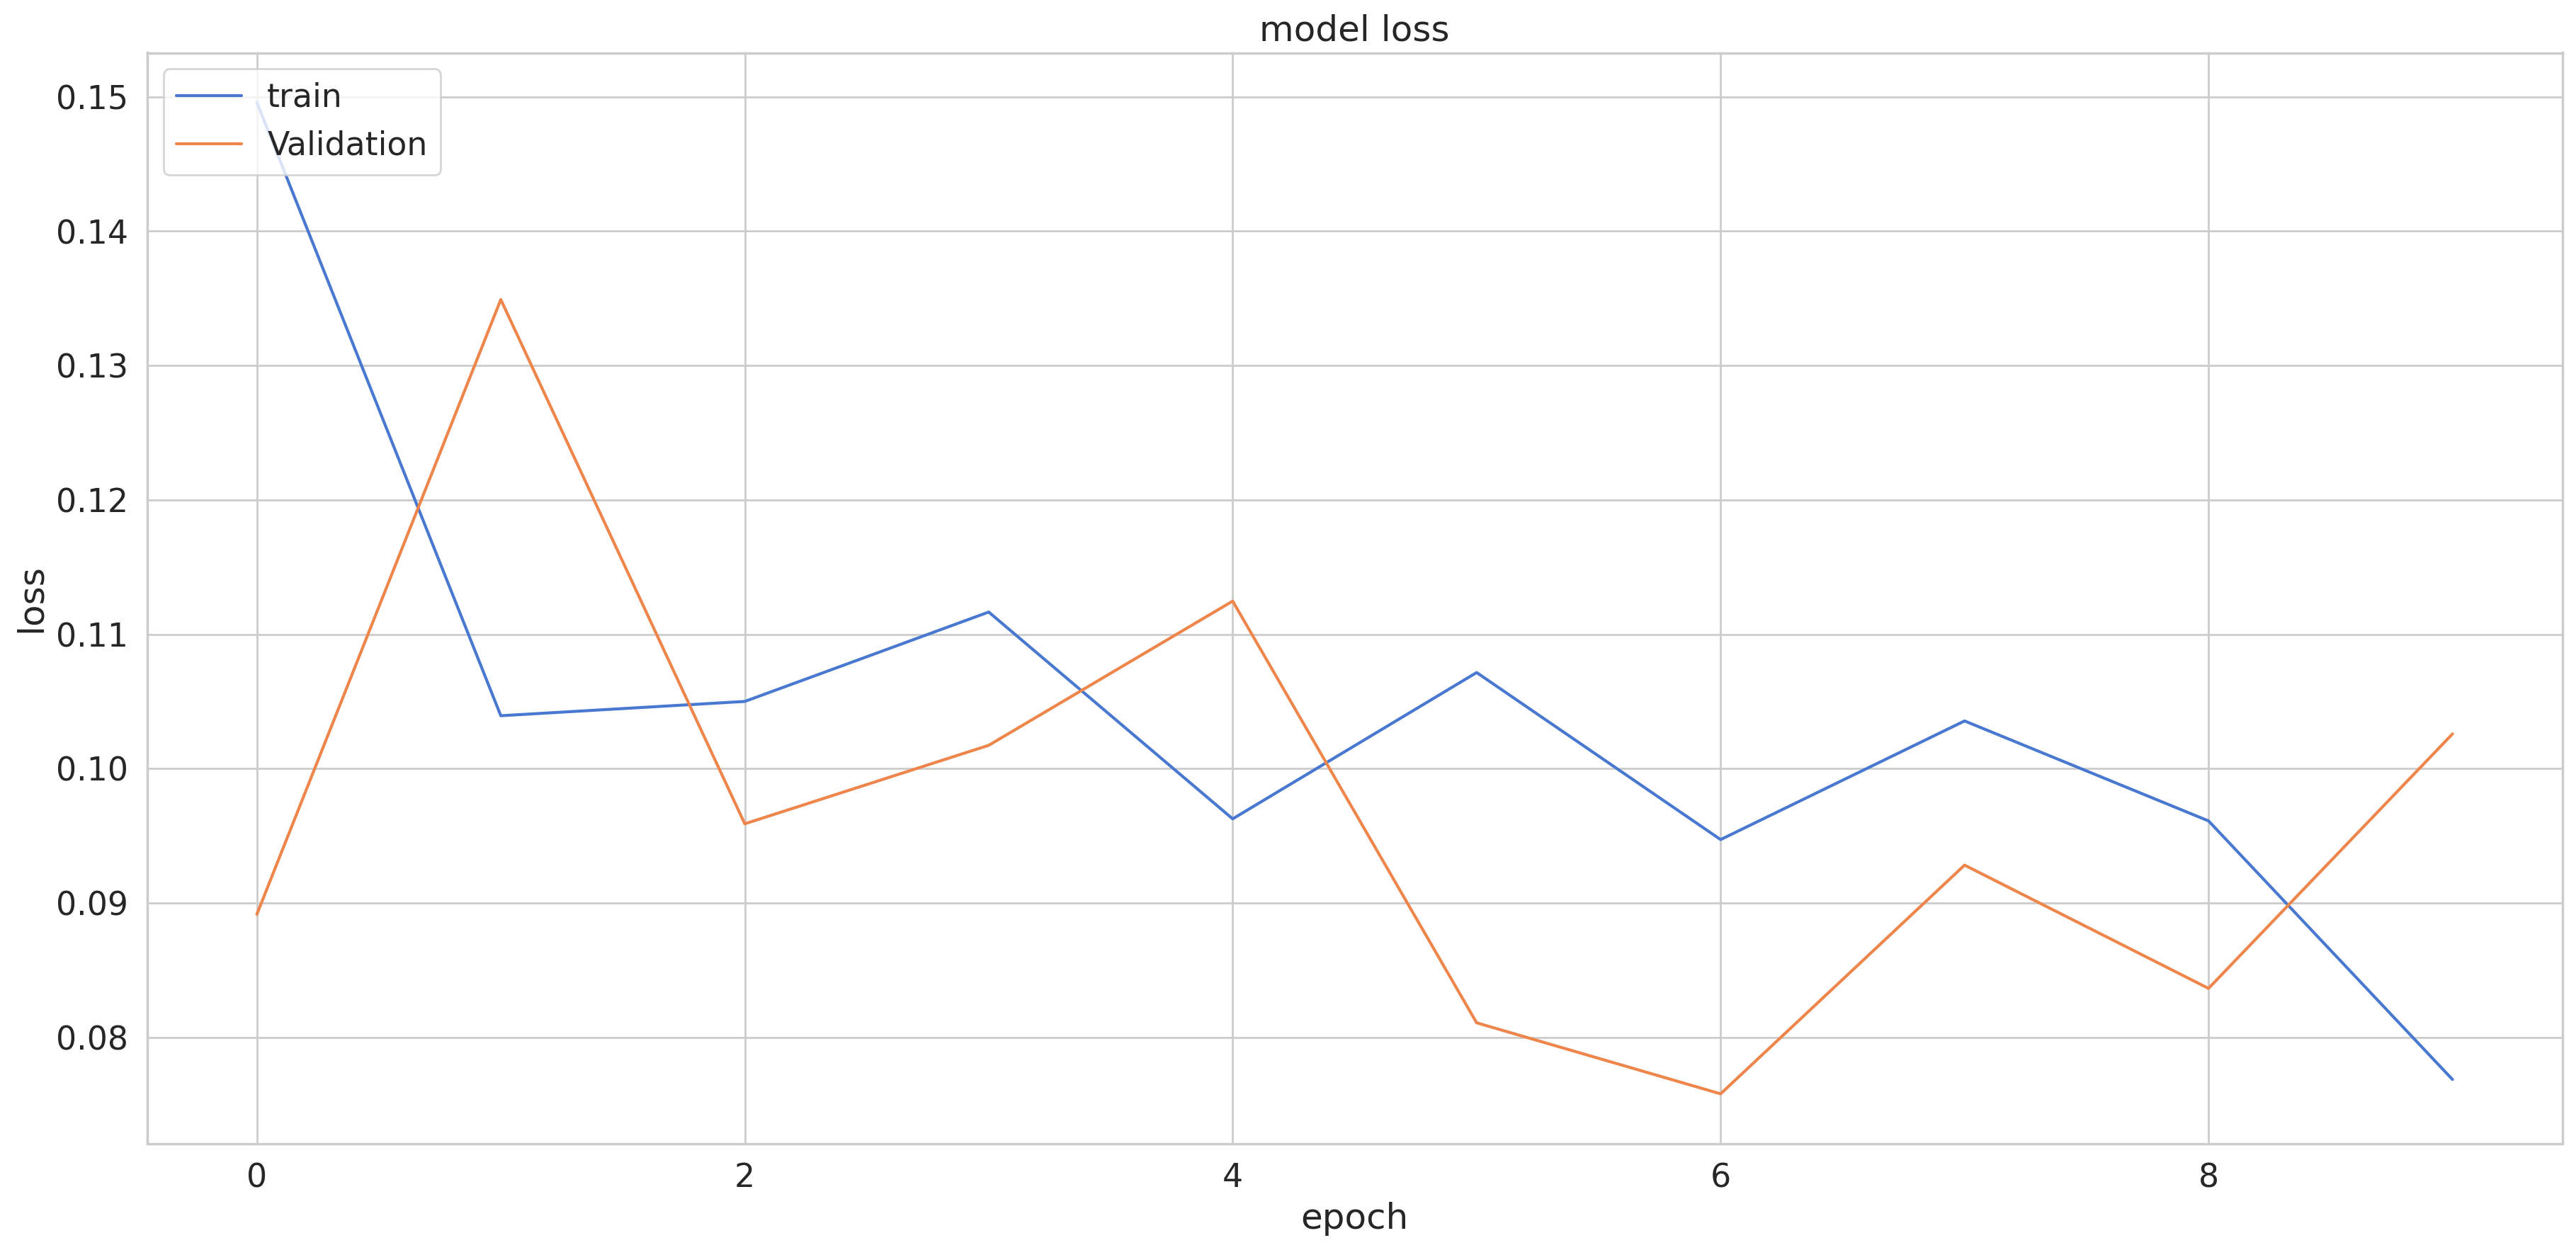

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

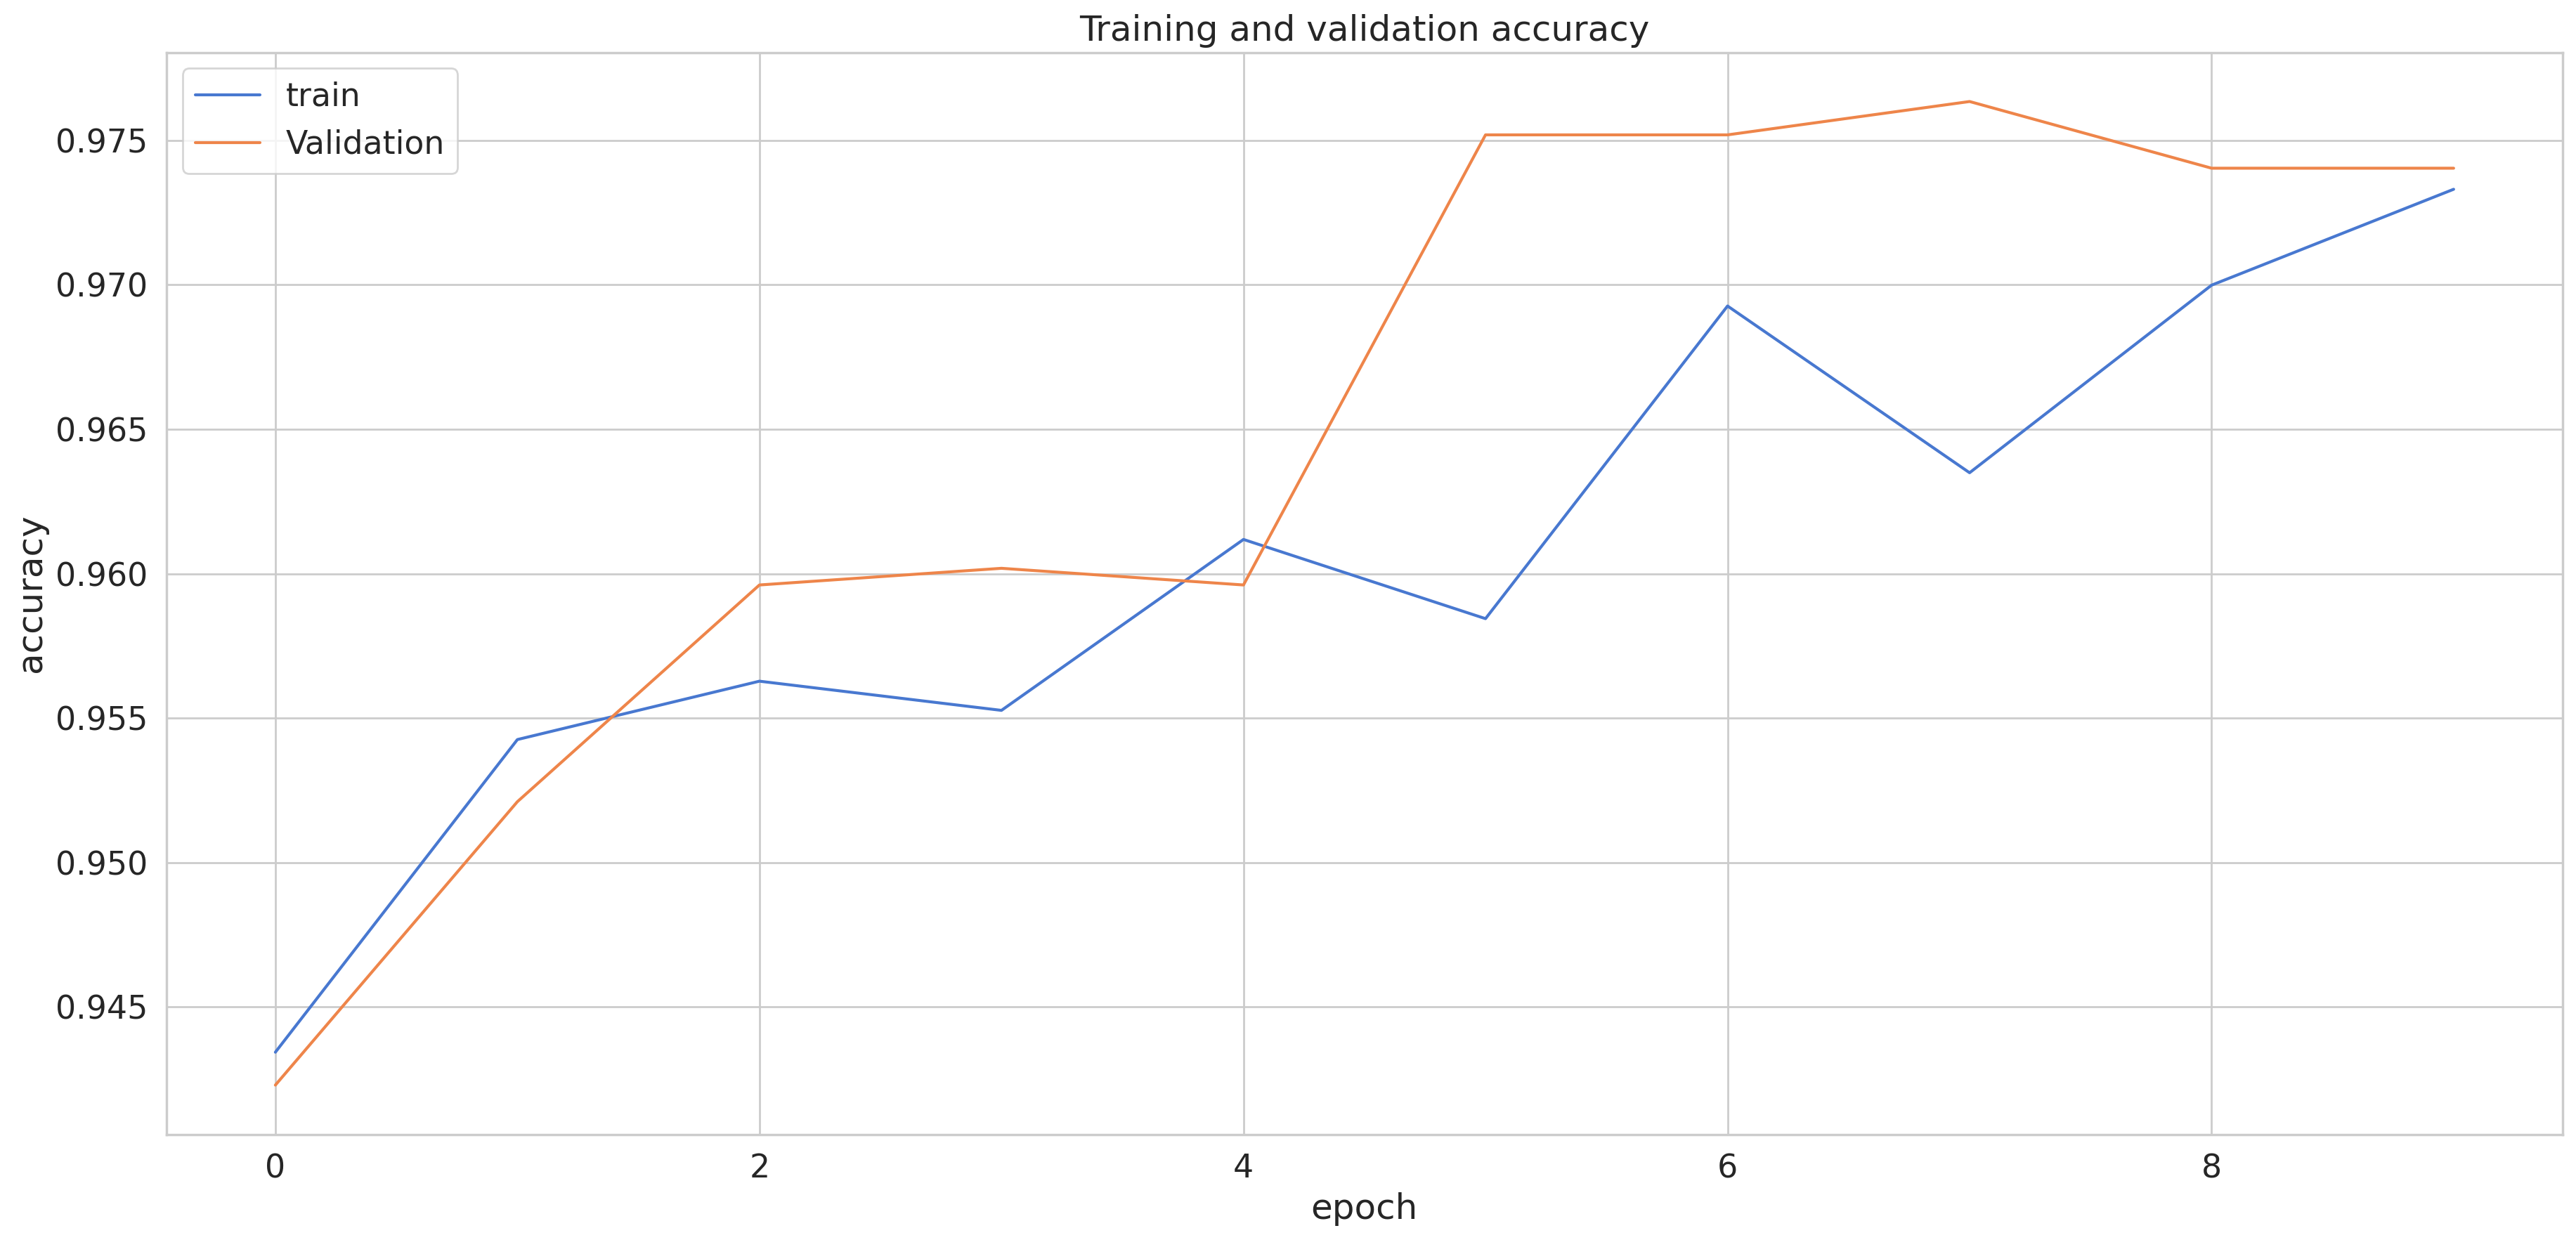

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 3s 11ms/step
f1_score =  0.9691380336395002
0.969067405355494
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1199
           1       0.94      1.00      0.97       967

    accuracy                           0.97      2166
   macro avg       0.97      0.97      0.97      2166
weighted avg       0.97      0.97      0.97      2166



<Axes: >

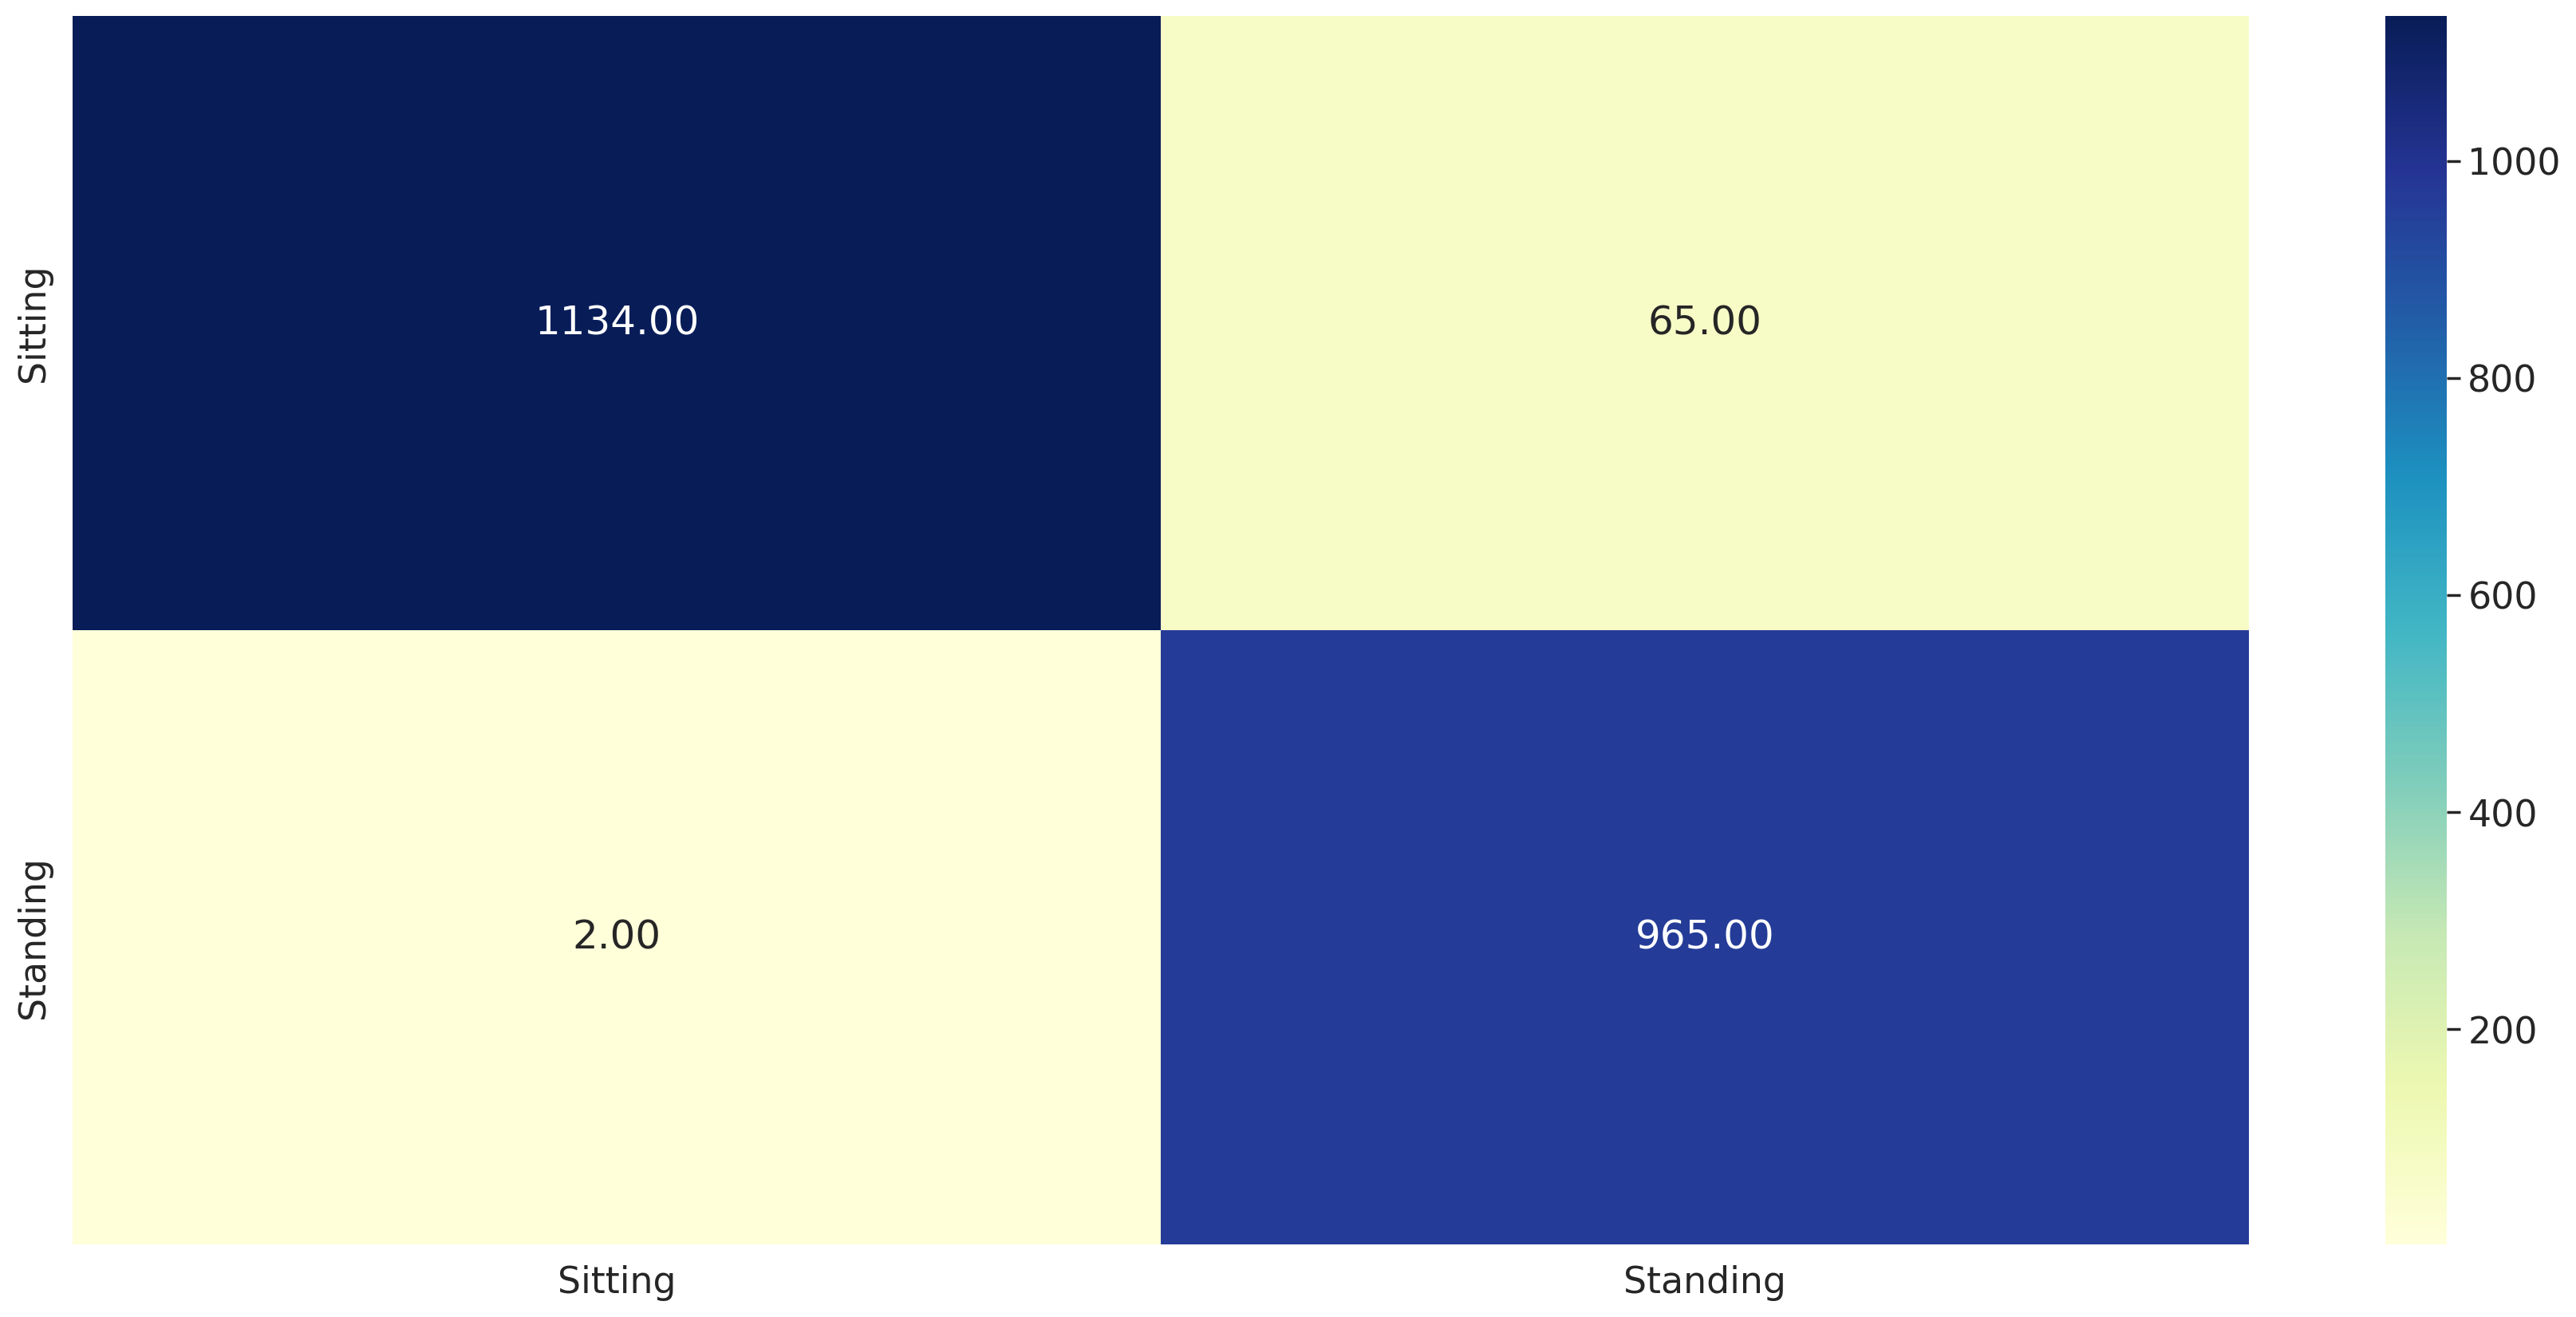

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [35]:
model = Sequential()
# RNN layer
model.add(Bidirectional(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))


model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 50, 256)           135168    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 50, 256)           394240    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 50, 256)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 50, 256)           394240    
 ional)                                                          
                                                      

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 25s 131ms/step - loss: 0.1452 - accuracy: 0.9496 - val_loss: 0.1064 - val_accuracy: 0.9585
Epoch 2/10
55/55 [==============================] - 3s 51ms/step - loss: 0.1010 - accuracy: 0.9547 - val_loss: 0.0934 - val_accuracy: 0.9602
Epoch 3/10
55/55 [==============================] - 3s 50ms/step - loss: 0.1057 - accuracy: 0.9548 - val_loss: 0.1465 - val_accuracy: 0.9342
Epoch 4/10
55/55 [==============================] - 3s 50ms/step - loss: 0.1631 - accuracy: 0.9545 - val_loss: 0.1571 - val_accuracy: 0.9573
Epoch 5/10
55/55 [==============================] - 3s 53ms/step - loss: 0.2312 - accuracy: 0.9149 - val_loss: 0.1125 - val_accuracy: 0.9694
Epoch 6/10
55/55 [==============================] - 3s 53ms/step - loss: 0.1170 - accuracy: 0.9675 - val_loss: 0.1782 - val_accuracy: 0.9233
Epoch 7/10
55/55 [==============================] - 3s 50ms/step - loss: 0.1431 - accuracy: 0.9596 - val_loss: 0.1229 - val_accuracy: 0.9625
Epoch 8/10


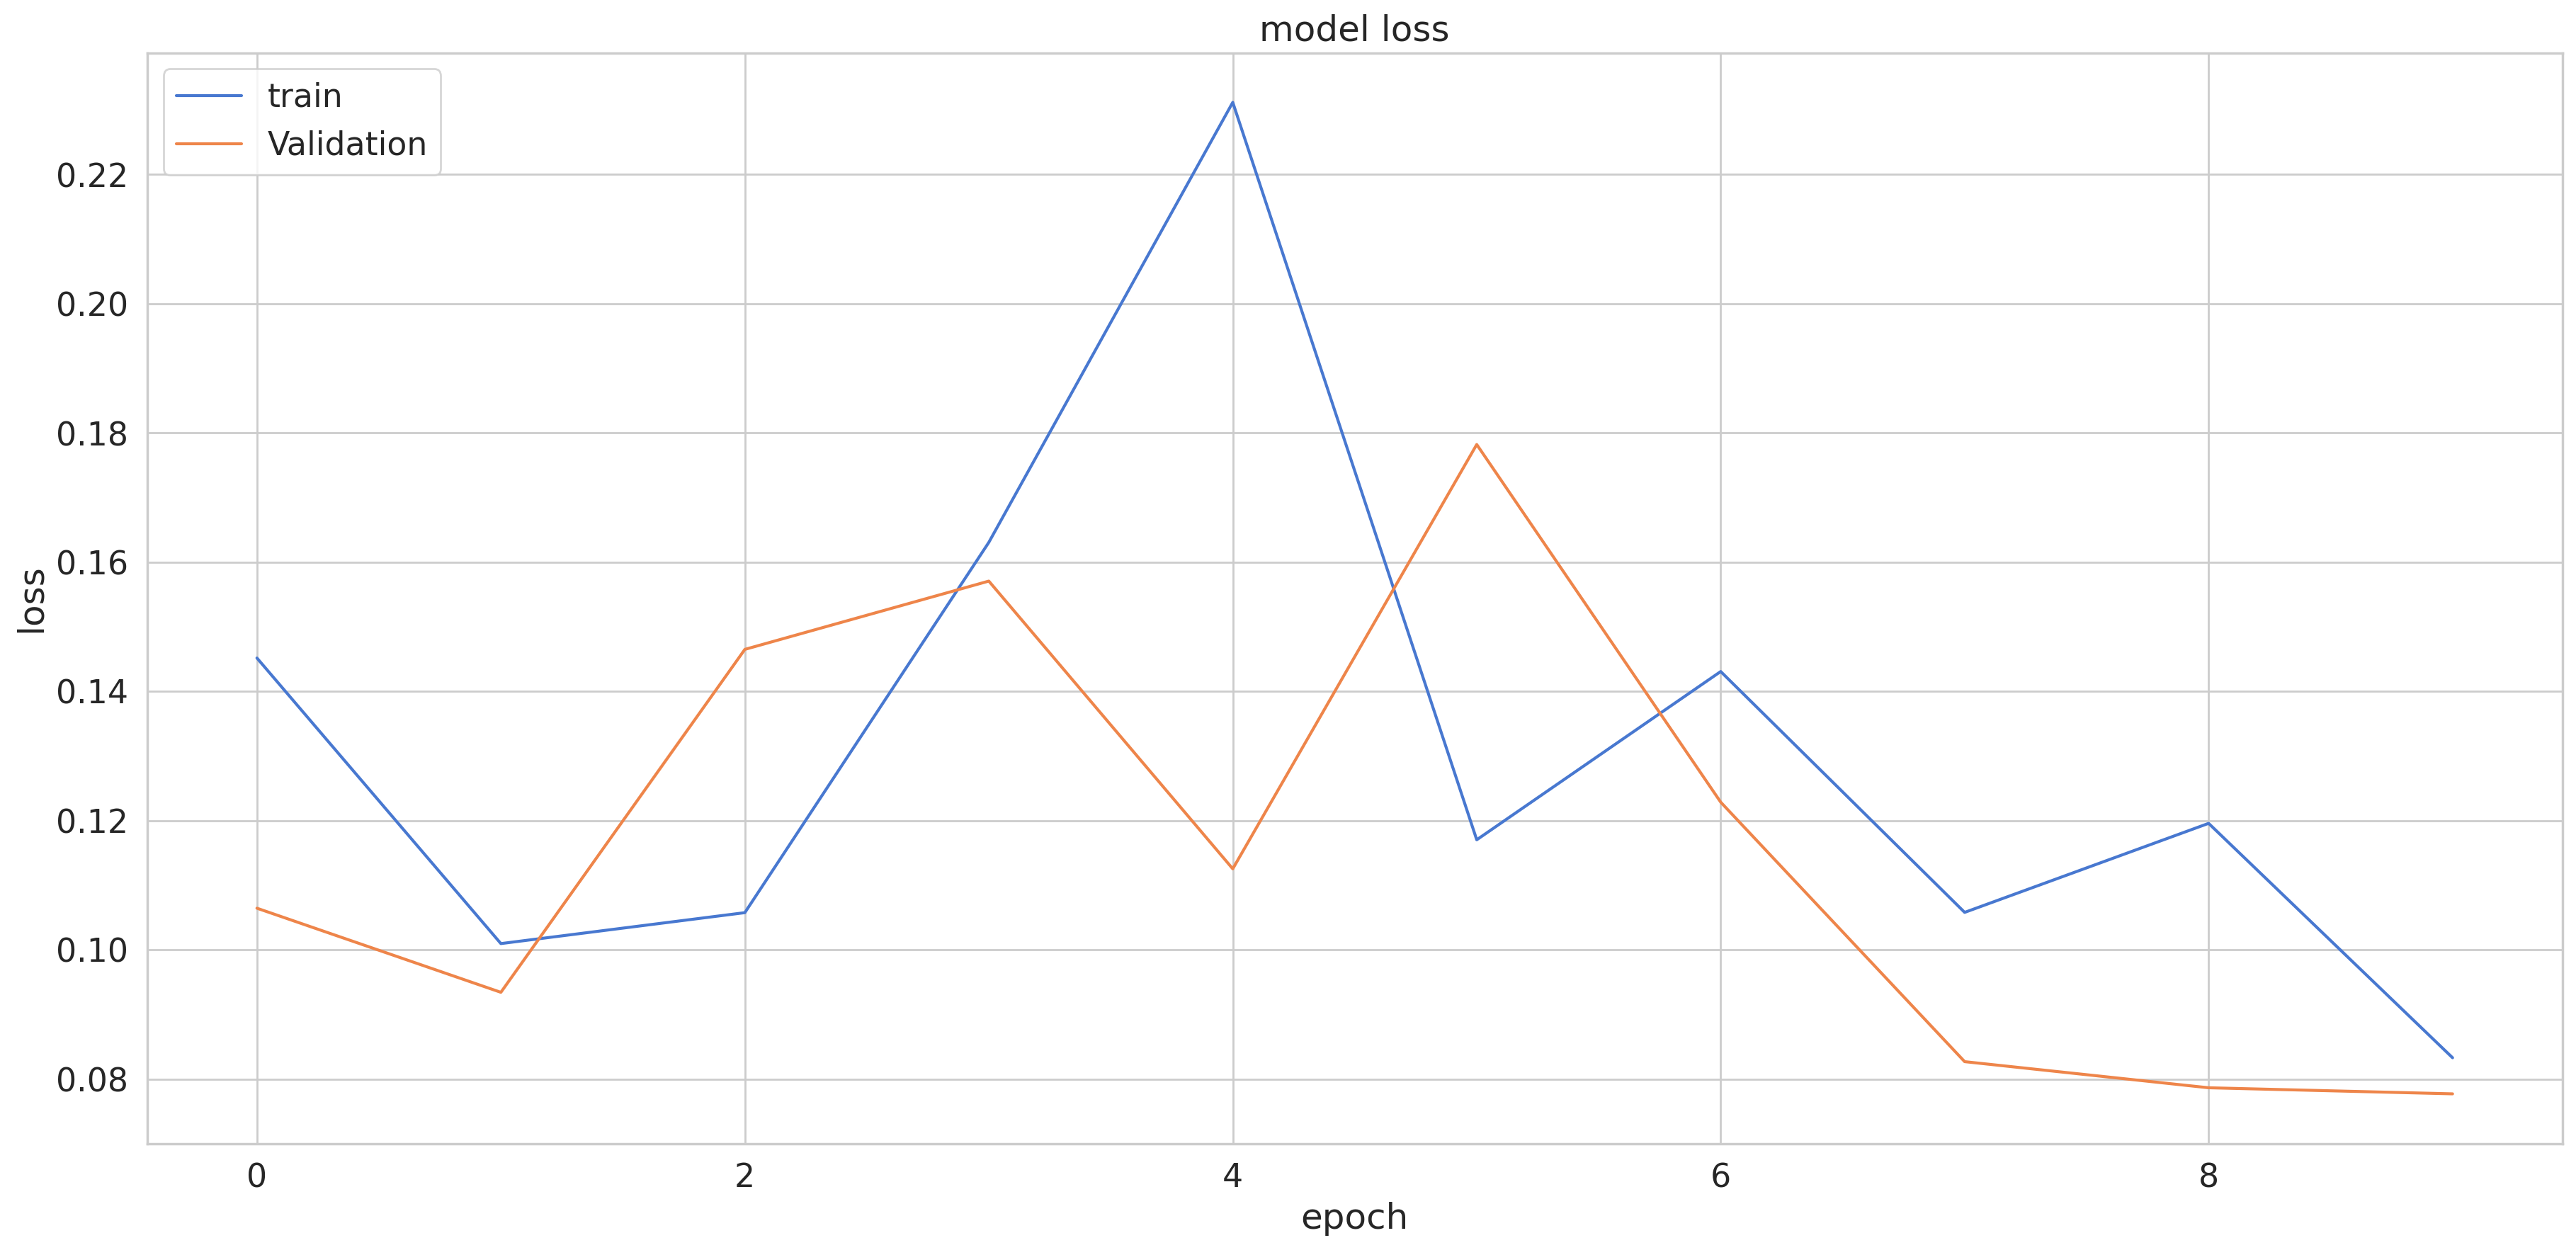

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

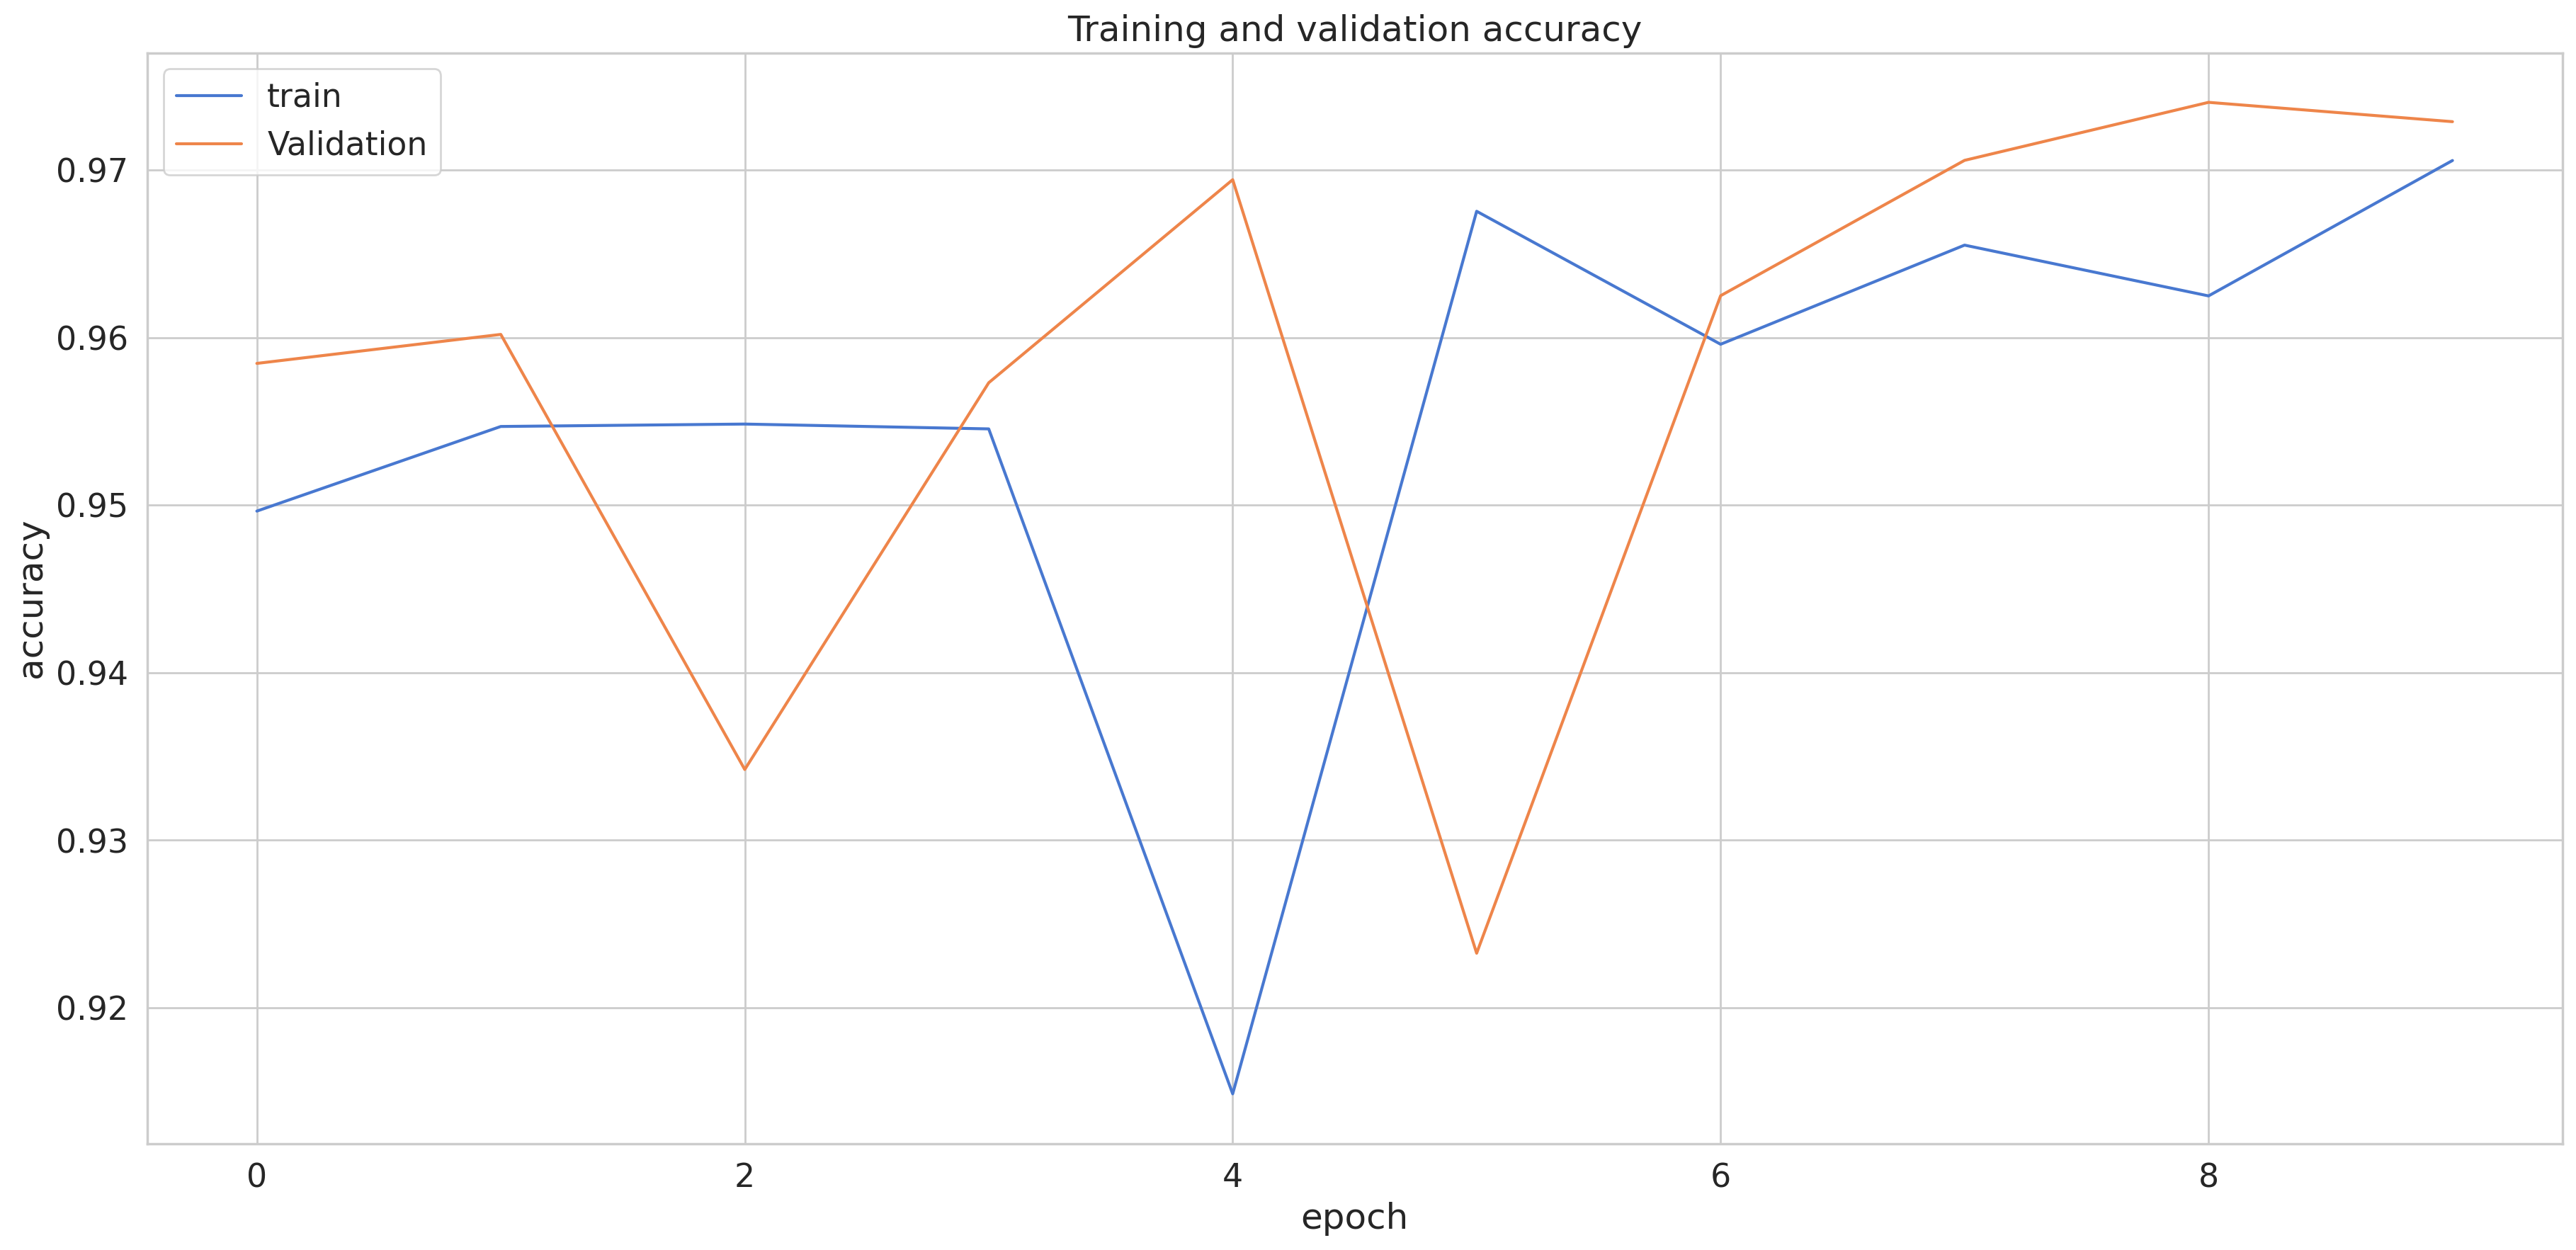

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 4s 15ms/step
f1_score =  0.9677539039176458
0.9676823638042474
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1199
           1       0.94      0.99      0.96       967

    accuracy                           0.97      2166
   macro avg       0.97      0.97      0.97      2166
weighted avg       0.97      0.97      0.97      2166



<Axes: >

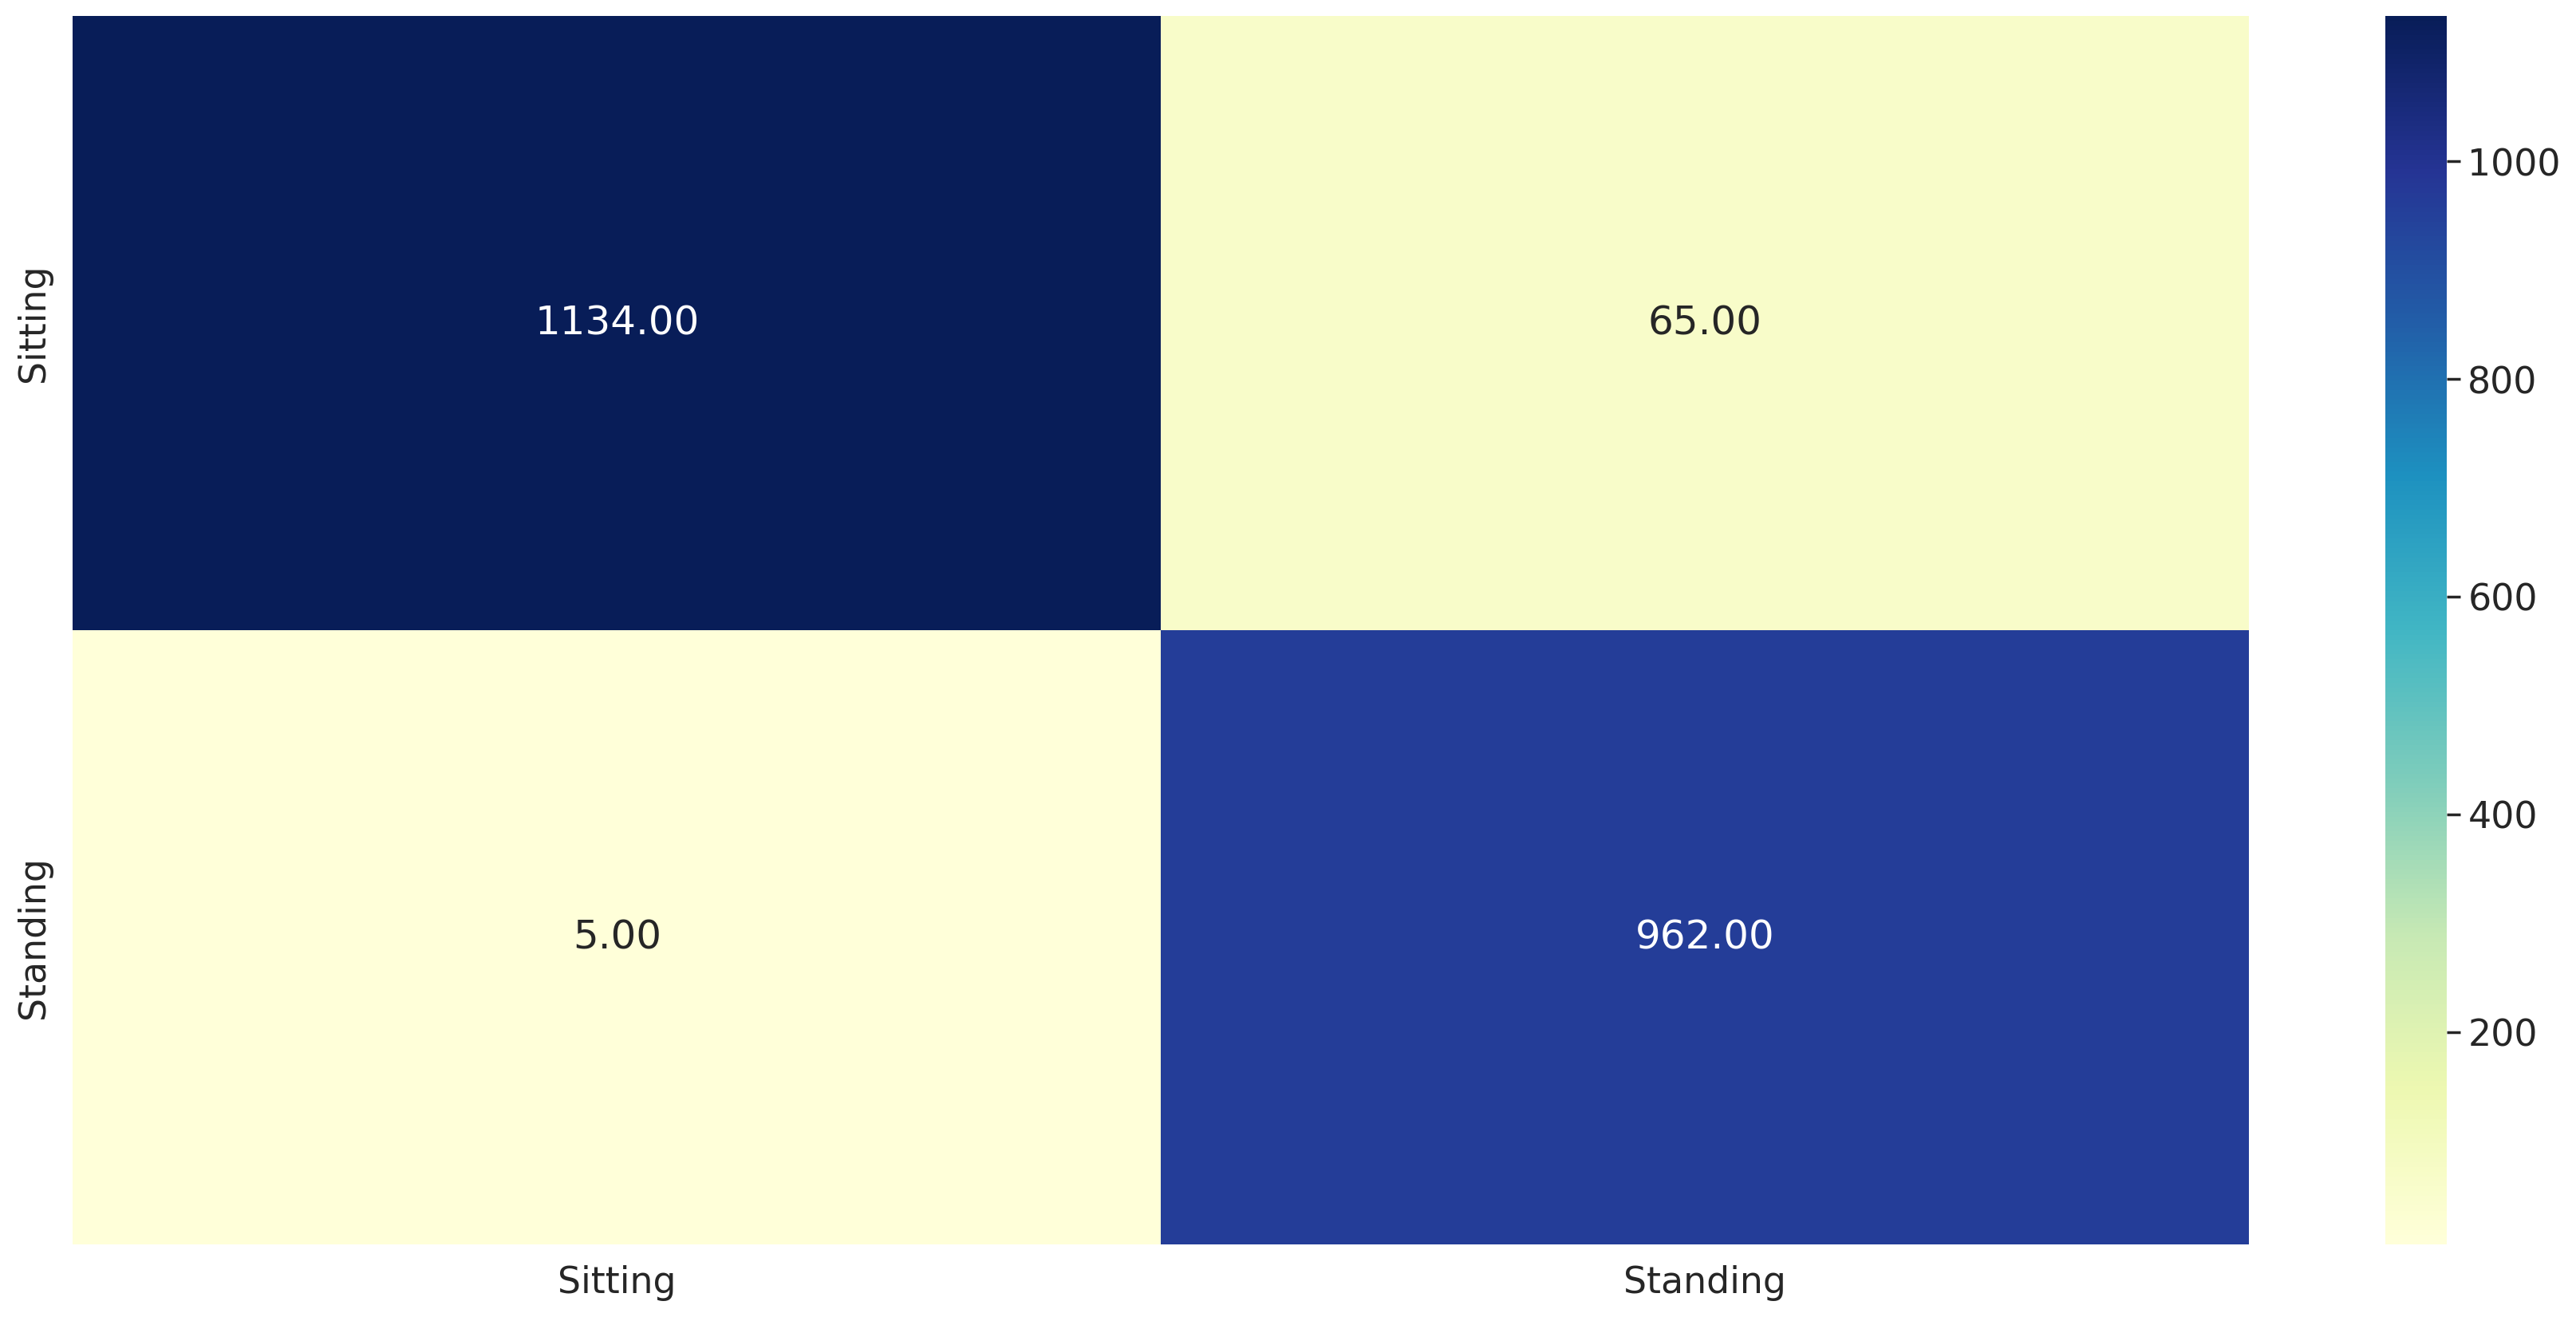

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')